Autor: Duo Xu
Fecha última modificación: 15 enero 2026

In [420]:
import glob
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from scipy.stats import chisquare
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
import requests
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge
from shapely.geometry import Point
from shapely import wkt

from neo4j import GraphDatabase
import shap

plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

In [188]:
REMOTE_BASE_PATH = '/tmp/pycharm_project_992'

file = "/tmp/pycharm_project_992/data/datasets/raw/Censo vertidos.xlsx"

df = pd.read_excel(file, header=4)

print("Primeras 5 filas:")
df.head()

print("\nInformación del DataFrame:")
df.info()

Primeras 5 filas:

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1837 entries, 0 to 1836
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              0 non-null      float64
 1   NOMBRE DEL VERTIDO      1836 non-null   object 
 2   TITULAR                 1835 non-null   object 
 3   MUNICIPIO DEL VERTIDO   1835 non-null   object 
 4   PROVINCIA VERTIDO       1835 non-null   object 
 5   UTM X 
Huso 30          1835 non-null   float64
 6   UTM Y 
Huso 30          1835 non-null   float64
 7   MEDIO     RECEPTOR      1835 non-null   object 
 8   NATURALEZA DEL VERTIDO  1835 non-null   object 
 9   CARACT. DEL VERTIDO     1835 non-null   object 
 10  VOLUMEN (m3/año)        1835 non-null   float64
 11  NATURALEZA M.RECEPTOR   1835 non-null   object 
 12  REF. EXPED.             1835 non-null   object 
dtypes: float64(4), object(9)
memory usage: 186.7+ K

# Limpieza

In [189]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

Limpiar y renombrar columnas para que sean más fáciles de usar (Quitar \n, espacios y paréntesis)

In [190]:
df.columns = df.columns.str.replace(r'\s+', ' ', regex=True).str.strip()

# Ahora ejecuta tu rename de nuevo
df = df.rename(columns={
    'NOMBRE DEL VERTIDO': 'NOMBRE_VERTIDO',
    'MUNICIPIO DEL VERTIDO': 'MUNICIPIO',
    'PROVINCIA VERTIDO': 'PROVINCIA',
    'UTM X Huso 30': 'UTM_X',
    'UTM Y Huso 30': 'UTM_Y',
    'MEDIO RECEPTOR': 'MEDIO_RECEPTOR',
    'NATURALEZA DEL VERTIDO': 'NATURALEZA_VERTIDO',
    'CARACT. DEL VERTIDO': 'CARACT_VERTIDO',
    'VOLUMEN (m3/año)': 'VOLUMEN_m3_ano',
    'NATURALEZA M.RECEPTOR': 'NATURALEZA_RECEPTOR',
    'REF. EXPED.': 'REF_EXPEDIENTE'
})

In [191]:
df.head()

,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE
0,DROMEN GESTORES Y CONSULTORES (VIV. UNIFAMILIAR),"DROMEN GESTORES Y CONSULTORES, S.L.",ADRADA (LA),AVILA,358144.0,4460601.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,231.0,CATEGORÍA I,AV-0006/2020
1,PIZZERIA-RESTAURANTE PUENTE MOCHA,PERSONA FÍSICA,ADRADA (LA),AVILA,358290.0,4459633.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,1188.0,CATEGORÍA I,AV-0049/1999
2,CENTRO HÍPICO LA ESPUELA,"CORPORACIÓN RILUMI, S.L.",ADRADA (LA),AVILA,358288.0,4459174.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,3650.0,CATEGORÍA I,AV-0041/2015
3,EDAR LA ADRADA,AYUNTAMIENTO DE LA ADRADA,ADRADA (LA),AVILA,359461.0,4460939.0,ARROYO FRANQUILLO,URBANO O ASIMILABLE,2.000-10.000 h-e,1193058.0,CATEGORÍA I,AV-0053/2014
4,PERSONA FÍSICA (VIVIENDAS),PERSONA FÍSICA,ADRADA (LA),AVILA,357353.0,4461118.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,102.0,CATEGORÍA I,AV-0041/2017


Eliminar las filas que tienen valores nulos en columnas clave (ej. TITULAR o MUNICIPIO) Esto eliminará 2 filas que parecían vacías

In [192]:
df = df.dropna(subset=['TITULAR', 'MUNICIPIO', 'VOLUMEN_m3_ano'])

In [193]:
print("Datos limpios:")
df.head()

Datos limpios:


,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE
0,DROMEN GESTORES Y CONSULTORES (VIV. UNIFAMILIAR),"DROMEN GESTORES Y CONSULTORES, S.L.",ADRADA (LA),AVILA,358144.0,4460601.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,231.0,CATEGORÍA I,AV-0006/2020
1,PIZZERIA-RESTAURANTE PUENTE MOCHA,PERSONA FÍSICA,ADRADA (LA),AVILA,358290.0,4459633.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,1188.0,CATEGORÍA I,AV-0049/1999
2,CENTRO HÍPICO LA ESPUELA,"CORPORACIÓN RILUMI, S.L.",ADRADA (LA),AVILA,358288.0,4459174.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,3650.0,CATEGORÍA I,AV-0041/2015
3,EDAR LA ADRADA,AYUNTAMIENTO DE LA ADRADA,ADRADA (LA),AVILA,359461.0,4460939.0,ARROYO FRANQUILLO,URBANO O ASIMILABLE,2.000-10.000 h-e,1193058.0,CATEGORÍA I,AV-0053/2014
4,PERSONA FÍSICA (VIVIENDAS),PERSONA FÍSICA,ADRADA (LA),AVILA,357353.0,4461118.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,102.0,CATEGORÍA I,AV-0041/2017


In [194]:
print("\nNueva información del DataFrame:")
df.info()


Nueva información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 1835 entries, 0 to 1834
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NOMBRE_VERTIDO       1835 non-null   object 
 1   TITULAR              1835 non-null   object 
 2   MUNICIPIO            1835 non-null   object 
 3   PROVINCIA            1835 non-null   object 
 4   UTM_X                1835 non-null   float64
 5   UTM_Y                1835 non-null   float64
 6   MEDIO_RECEPTOR       1835 non-null   object 
 7   NATURALEZA_VERTIDO   1835 non-null   object 
 8   CARACT_VERTIDO       1835 non-null   object 
 9   VOLUMEN_m3_ano       1835 non-null   float64
 10  NATURALEZA_RECEPTOR  1835 non-null   object 
 11  REF_EXPEDIENTE       1835 non-null   object 
dtypes: float64(3), object(9)
memory usage: 186.4+ KB


Clasificar los titulares

In [195]:
def clasificar_titular(titular):
    """
    Clasifica el titular basándose en ciertas palabras clave.
    Retorna: 'A', 'F', 'J', o np.nan si no se clasifica.
    """
    if pd.isna(titular):
        return np.nan  # Manejar valores nulos si existen

    # Convertir a mayúsculas para asegurar una búsqueda sin distinción
    titular_upper = str(titular).upper()

    # Clasificación 'A' - AYUNTAMIENTO
    terminos_admin = ['AYUNTAMIENTO', 'MINISTERIO', 'JUNTA', 'ACUARTELAMIENTO']
    if any(term in titular_upper for term in terminos_admin):
        return 'A'

    # Clasificación 'F' - PERSONA FÍSICA
    # Buscamos 'PERSONA FÍSICA' o sinónimos comunes de 'particular'
    if 'PERSONA FÍSICA' in titular_upper or 'PARTICULAR' in titular_upper:
        return 'F'

    # Clasificación 'J' - PERSONAS JURÍDICAS (Sociedades)
    # Lista de términos comunes para personas jurídicas
    terminos_juridicos = ['S.L.', 'SL.', 'S.L', 'S. A.', 'SA.', 'S.A', 'SOCIEDAD', 'CORPORACION', 'FUNDACIÓN', 'SLU',
                          'SAU', 'SRL', 'COMUNIDAD', 'COM', 'ASOCIACIÓN', 'PARROQUIA']

    # Verificamos si alguno de los términos jurídicos está en el titular
    if any(term in titular_upper for term in terminos_juridicos):
        return 'J'

    # Si no coincide con ninguna de las categorías anteriores
    return np.nan  # Usamos np.nan (Not a Number) para indicar no clasificado

In [196]:
df['tipo_titular'] = df['TITULAR'].apply(clasificar_titular)

In [197]:
df[df['tipo_titular'].isnull()]

,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,tipo_titular
13,RESTAURANTE GRUTAS DEL AGUILA,"HERMANOS MUÑOZ PEREDA, C.B.",ARENAS DE SAN PEDRO,AVILA,323675.0,4447222.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,2600.0,CATEGORÍA I,AV-0050/1999,NaN
33,EATON PLANNING LIMITED (VIV. UNIFAMILIAR),EATON PLANNING LIMITED,ARENAS DE SAN PEDRO,AVILA,317131.0,4441014.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,438.0,CATEGORÍA I,AV-0111/2011,NaN
59,CAMPAMENTO SANTA MARÍA DEL MONTE,CONGREGACIÓN LEGIONARIOS DE CRISTO,BURGOHONDO,AVILA,348368.0,4473405.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,730.0,CATEGORÍA I,AV-0020/2019,NaN
119,HOSTELERÍA EL CORRALÓN,GREDOS SAN DIEGO S. COOP. MAD.,CASAVIEJA,AVILA,348843.0,4462227.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,6000.0,CATEGORÍA I,AV-0072/2021,NaN
178,COLONIA INFANTIL VENERO CLARO,CAJA DE AHORROS Y M. DE P. DE AVILA,NAVALUENGA,AVILA,358772.0,4474592.0,GARGANTA CABRERA,URBANO O ASIMILABLE,<2.000 h-e,2000.0,CATEGORÍA I,AV-0027/1994,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,URB. VEGA DEL CASTILLO,E.U.C.C. VEGA DEL CASTILLO,VISO DE SAN JUAN (EL),TOLEDO,415310.0,4443982.0,RÍO GUADARRAMA,URBANO O ASIMILABLE,<2.000 h-e,7300.0,CATEGORÍA I,AV-0050/2009,NaN
1820,URB. LAS ZANJAS,E.U.C.C. LAS ZANJAS,VISO DE SAN JUAN (EL),TOLEDO,419571.0,4444971.0,AFLUENTE DEL ARROYO VALSECO,URBANO O ASIMILABLE,<2.000 h-e,11680.0,CATEGORÍA I,AV-0104/2008,NaN
1822,URB. CAMINO DE LOS FRAILES,E.U.C.C. CAMINO DE LOS FRAILES,VISO DE SAN JUAN (EL),TOLEDO,414490.0,4444673.0,ARROYO PRADO DE LOS CABALLOS,URBANO O ASIMILABLE,<2.000 h-e,16425.0,CATEGORÍA I,AV-0090/2001,NaN
1823,URB. SAN MARCOS,E.U.C.C. URB. SAN MARCOS,VISO DE SAN JUAN (EL),TOLEDO,415794.0,4444407.0,RÍO GUADARRAMA,URBANO O ASIMILABLE,<2.000 h-e,34310.0,CATEGORÍA I,AV-0605/1987,NaN


In [198]:
df.head()

,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,tipo_titular
0,DROMEN GESTORES Y CONSULTORES (VIV. UNIFAMILIAR),"DROMEN GESTORES Y CONSULTORES, S.L.",ADRADA (LA),AVILA,358144.0,4460601.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,231.0,CATEGORÍA I,AV-0006/2020,J
1,PIZZERIA-RESTAURANTE PUENTE MOCHA,PERSONA FÍSICA,ADRADA (LA),AVILA,358290.0,4459633.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,1188.0,CATEGORÍA I,AV-0049/1999,F
2,CENTRO HÍPICO LA ESPUELA,"CORPORACIÓN RILUMI, S.L.",ADRADA (LA),AVILA,358288.0,4459174.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,3650.0,CATEGORÍA I,AV-0041/2015,J
3,EDAR LA ADRADA,AYUNTAMIENTO DE LA ADRADA,ADRADA (LA),AVILA,359461.0,4460939.0,ARROYO FRANQUILLO,URBANO O ASIMILABLE,2.000-10.000 h-e,1193058.0,CATEGORÍA I,AV-0053/2014,A
4,PERSONA FÍSICA (VIVIENDAS),PERSONA FÍSICA,ADRADA (LA),AVILA,357353.0,4461118.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,102.0,CATEGORÍA I,AV-0041/2017,F


# Visualización inicial del Dataframe

In [199]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1835 entries, 0 to 1834
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NOMBRE_VERTIDO       1835 non-null   object 
 1   TITULAR              1835 non-null   object 
 2   MUNICIPIO            1835 non-null   object 
 3   PROVINCIA            1835 non-null   object 
 4   UTM_X                1835 non-null   float64
 5   UTM_Y                1835 non-null   float64
 6   MEDIO_RECEPTOR       1835 non-null   object 
 7   NATURALEZA_VERTIDO   1835 non-null   object 
 8   CARACT_VERTIDO       1835 non-null   object 
 9   VOLUMEN_m3_ano       1835 non-null   float64
 10  NATURALEZA_RECEPTOR  1835 non-null   object 
 11  REF_EXPEDIENTE       1835 non-null   object 
 12  tipo_titular         1490 non-null   object 
dtypes: float64(3), object(10)
memory usage: 200.7+ KB
None


Vamos a mirar primero el asunto de los titulares nulos, es la única columna nula que tenemos

In [200]:
df[df['tipo_titular'].isna()].groupby('TITULAR').count().sort_values(by='NOMBRE_VERTIDO', ascending=False)

,NOMBRE_VERTIDO,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,tipo_titular
TITULAR,,,,,,,,,,,,
CANAL DE ISABEL II,166,166,166,166,166,166,166,166,166,166,166,0
CONSORCIO DE SS. PP. MEDIOAMBIENTALES DE TOLEDO,7,7,7,7,7,7,7,7,7,7,7,0
"CENTRAL NUCLEAR DE TRILLO I, C.B.",4,4,4,4,4,4,4,4,4,4,4,0
C.B. CENTRAL NUCLEAR DE ALMARAZ,3,3,3,3,3,3,3,3,3,3,3,0
ADMINISTRADOR DE INFRAESTRUCTURAS FERROVIARIAS (ADIF),3,3,3,3,3,3,3,3,3,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
UNIVERSIDAD AUTONOMA DE MADRID,1,1,1,1,1,1,1,1,1,1,1,0
"UNIÓN DE AGRICULTORES DE RIOLOBOS, S.C.L.",1,1,1,1,1,1,1,1,1,1,1,0
UNIÓN DE IGLESIAS ADVENTISTAS DEL SÉPTIMO DÍA (UICASDE),1,1,1,1,1,1,1,1,1,1,1,0


Vemos rápidamente que podemos imputar una gran cantidad de ellos al Canal de Isabel II. Ahora preparamos la función v2 para cazar nulos a medida

In [201]:
def clasificar_titular_v2(titular):
    """
    Clasifica el titular basándose en ciertas palabras clave.
    Retorna: 'A', 'F', 'J', o np.nan si no se clasifica.
    """
    if pd.isna(titular):
        return np.nan  # Manejar valores nulos si existen

    # Convertir a mayúsculas para asegurar una búsqueda sin distinción
    titular_upper = str(titular).upper()

    # Clasificación 'A' - ADMIN PÚBLICA
    terminos_admin = [
        # Entidades Locales
        'AYUNTAMIENTO', 'DIPUTACIÓN', 'JUNTA', 'CONSEJERÍA', 'MANCOMUNIDAD',
        'CONSORCIO', 'CABILDO', 'CONSELL', 'E.A.T.I.M.', 'EATIM', 'ENTIDAD LOCAL',
        'ADM. LOCAL', 'SAECO',
        # Administración General y Organismos Públicos
        'MINISTERIO', 'Mº ', 'GOBIERNO', 'CONFEDERACIÓN', 'AGENCIA', 'INSTITUTO', 'INST.',
        'ADIF', 'RENFE', 'PUERTOS DEL ESTADO', 'CH ', 'C.H.',
        'CEDEX', 'I.N.T.A.', ' INTA ', 'PENITENCIARIO', 'CONSEJERIA', 'PARQUES NACIONALES',
        'DIPUTACION',  # Organismos técnicos específicos
        # Defensa
        'DEFENSA', 'EJÉRCITO', 'ARMADA', 'GUARDIA CIVIL', 'POLICÍA',
        'ACUARTELAMIENTO', 'CUARTEL', 'BASE ', 'ACADEMIA DE', 'BRIAC', 'SERVICIO DE SALUD',
        # Instrumental
        'CANAL DE ISABEL', 'INFRAESTRUCTURAS DEL AGUA', 'UNIVERSIDAD', 'HOSPITAL', 'COLEGIO'
    ]

    if any(term in titular_upper for term in terminos_admin):
        return 'A'

    # Clasificación 'F' - PERSONA FÍSICA
    # Buscamos 'PERSONA FÍSICA' o sinónimos comunes de 'particular'
    if 'PERSONA FÍSICA' in titular_upper or 'PARTICULAR' in titular_upper:
        return 'F'

    # Clasificación 'J' - PERSONAS JURÍDICAS (Sociedades)
    # Lista de términos comunes para personas jurídicas
    terminos_juridicos = [
        # Sociedades Mercantiles y Financieras
        'S.L.', 'SL.', ' S.L', 'S. A.', 'SA.', ' S.A', 'SOCIEDAD', 'CORPORACION',
        'S.A.U.', 'SLU', 'S.R.L.', 'LIMITED', 'LTD', 'CAJA DE AHORROS', 'BANCO',
        'SAU', 'S.A.T.', 'IBERDROLA',
        # Cooperativas, Colectivos y Herederos
        'S.C.L.', 'S. COOP', 'SOC. COOP', 'COOPERATIVA', 'U.T.E.', 'AGRUPACIÓN',
        'HROS.', 'HEREDEROS', 'SUCESORES', 'UTE', 'UNIÓN DE',
        # Entidades Sin Ánimo de Lucro / Gestión Urbanística
        'ASOCIACIÓN', 'ASOCIACION', 'ASOC.', 'FUNDACIÓN', 'FUNDACION', 'CLUB', 'CASINO', 'LIGA ',
        'CENTRO ASTURIANO',  # Excepción específica privada
        'COMUNIDAD', 'COM. PROP.', 'C.P.', 'C.P ',  # Comunidades Propietarios
        'C.B.', ' C.B', 'CB ',
        'E.U.C.', 'E.U.', 'E.C.', 'ENTIDAD URBANÍSTICA', 'USBA',  # Entidades Urbanísticas
        # Entidades Religiosas (Nuevo bloque fuerte)
        'PARROQUIA', 'ARZOBISPADO', 'OBISPADO', 'COFRADÍA', 'CONGREGACIÓN', 'HERMANDAD',
        'ORDEN', 'CONVENTO', 'COTTOLENGO', 'ESCUELAS PIAS', 'FRATERNIDAD',
        'HIJAS DE', 'HOGAR ', 'INSPECTORÍA', 'SALESIANA', 'MISIONERAS', 'OBRA DE',
        'MOVIMIENTO', 'IGLESIA', 'SANTUARIO', 'SAGRADA', 'SALESIANOS',
        # Sectores
        'CENTRAL NUCLEAR', 'RESIDENCIA', 'HOTEL', 'CAMPING', 'DIST.', 'COM.'
    ]

    # Verificamos si alguno de los términos jurídicos está en el titular
    if any(term in titular_upper for term in terminos_juridicos):
        return 'J'

    # Si no coincide con ninguna de las categorías anteriores
    return np.nan  # Usamos np.nan (Not a Number) para indicar no clasificado

In [202]:
df['tipo_titular'] = df['TITULAR'].apply(clasificar_titular_v2)

In [203]:
df[df['tipo_titular'].isna()].groupby('TITULAR').count().sort_values(by='NOMBRE_VERTIDO', ascending=False)

,NOMBRE_VERTIDO,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,tipo_titular
TITULAR,,,,,,,,,,,,


Estadísticas numéricas básicas para comprender la dimensionalidad de los datos con los que estamos tratando

In [204]:
print("Estadísticas Numéricas:")
display(df.describe())

Estadísticas Numéricas:


,UTM_X,UTM_Y,VOLUMEN_m3_ano
count,1835.000000,1.835000e+03,1.835000e+03
mean,382654.700272,4.460158e+06,9.144975e+05
std,101425.402581,3.767816e+04,1.812940e+07
min,110450.000000,4.343955e+06,2.800000e+00
25%,306867.000000,4.439099e+06,3.831250e+02
50%,409985.000000,4.459069e+06,2.464000e+03
75%,453227.500000,4.484953e+06,4.493900e+04
max,624927.000000,4.563920e+06,7.570661e+08


Existe una enorme dispersión en el volumen. La media es ~914,000 m3, pero la desviación estándar es muy alta (1.8×107), indicando la presencia de vertidos industriales o EDARs muy grandes frente a muchos vertidos pequeños.

In [205]:
print("\nEstadísticas Categóricas:")
display(df.describe(include='object'))


Estadísticas Categóricas:


,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,tipo_titular
count,1835,1835,1835,1835,1835,1835,1835,1835,1835,1835
unique,1616,986,591,9,571,2,10,2,1834,3
top,PERSONA FÍSICA (VIV. UNIFAMILIAR),PERSONA FÍSICA,CANDELEDA,MADRID,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,CATEGORÍA I,AV-0120/2023,J
freq,199,394,55,585,912,1711,1435,1798,2,785


Madrid es la provincia con mayor frecuencia de vertidos registrados (585), seguida de otras provincias.

La inmensa mayoría (1,711 de 1,835) son de naturaleza URBANO O ASIMILABLE
Medio Receptor: El medio receptor más común es TERRENO 912 casos

In [206]:
df['MEDIO_RECEPTOR'].unique()

array(['TERRENO', 'ARROYO FRANQUILLO', 'RÍO EL ARENAL',
       'ARROYO BARRITOTE', 'ARROYO EGIDO', 'RÍO ALBERCHE',
       'ARROYO DE LA PARRA', 'ARROYO DE LOS CHARQUILLOS',
       'GARGANTA DE IRUELAS', 'ARROYO NOGALERA', 'ARROYO DE VALDIBUJO',
       'REGUERO DE LAS POZAS', 'ARROYO DE VALDEMARQUINA',
       'ARROYO DE LOS GALAYOS', 'GARGANTA DE LAS TORRES', 'ARROYO PELAYO',
       'RÍO CANTOS', 'ARROYO DE LA PEGUERA', 'ARROYO MERDERO',
       'ARROYO NAVAHERMOSA', 'RÍO RAMACASTAÑAS', 'ARROYO LAS HUERTAS',
       'ARROYO LOS MORALES', 'ARROYO PRADOMOLINO', 'GARGANTA CABRERA',
       'ARROYO CONEJERO', 'ARROYO DEL REGAJO', 'ARROYO DE LAS CASAS',
       'ARROYO DE VALLE ENMEDIO', 'RÍO ACEÑA', 'GARGANTA NUÑO COJO',
       'BARRANCO VALLE', 'RÍO TIÉTAR', 'RÍO PIQUILLO',
       'ARROYO DE FUENTE HERRADA', 'RÍO AMBROZ',
       'ARROYO DE LA FUENTE DE LA ESCOBA', 'ARROYO BARQUERA',
       'ARROYO BARRIGADILLA', 'ARROYO PALOMERO', 'ARROYO LA PILETA',
       'RÍO TAJO', 'ARROYO ROAGREA', 'ARROY

Está bastante completo este dataset, se pueden hacer muchas cosas con el medio receptor o los demás

conteo de vertidos por provincia

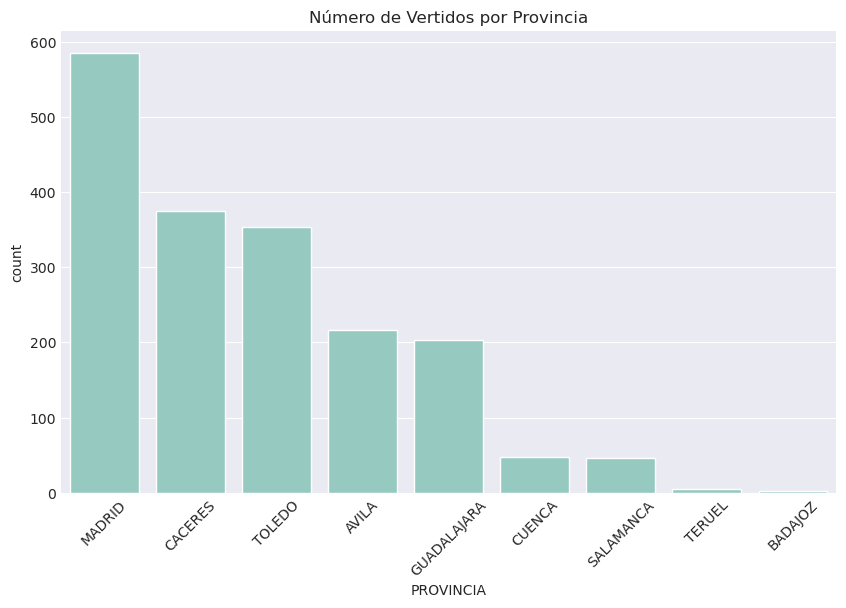

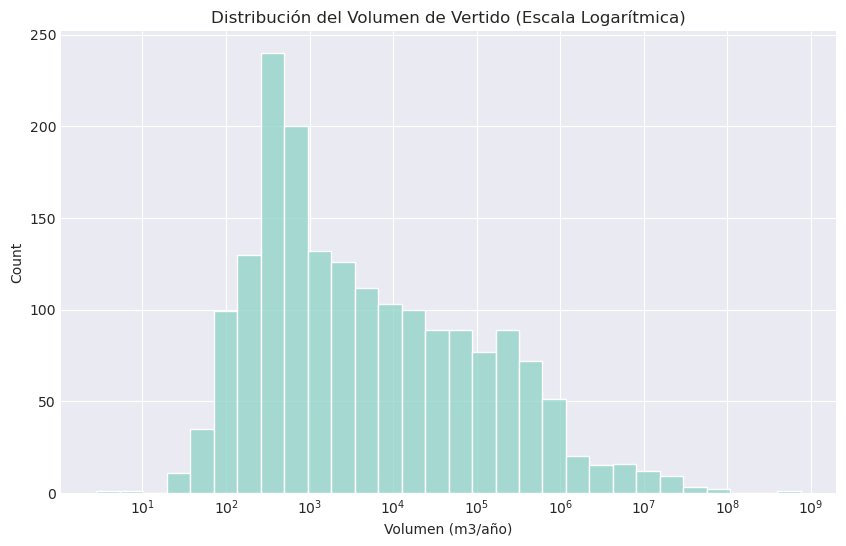

In [207]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='PROVINCIA', order=df['PROVINCIA'].value_counts().index)
plt.title('Número de Vertidos por Provincia')
plt.xticks(rotation=45)
plt.show()

# Distribución del Volumen en escala Logarítmica
plt.figure(figsize=(10, 6))
sns.histplot(df['VOLUMEN_m3_ano'], bins=30, log_scale=True)
plt.title('Distribución del Volumen de Vertido (Escala Logarítmica)')
plt.xlabel('Volumen (m3/año)')
plt.show()

In [208]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['UTM_X'], df['UTM_Y']),
    crs="EPSG:32630"  # Proyección UTM Zona 30N
)

# Clustering Espacial basado en Densidad (DBSCAN)
# Identifica clústeres de vertidos geográficamente cercanos automáticamente
# eps=5000 (5km de radio), min_samples=3
coords = df[['UTM_X', 'UTM_Y']].values
db = DBSCAN(eps=5000, min_samples=3, algorithm='ball_tree').fit(coords)

# Guardamos el cluster en el gdf original
gdf['cluster_id'] = db.labels_

print("Cálculos y geometría UTM generados correctamente.")

Cálculos y geometría UTM generados correctamente.


Vamos a crear un mapa de calor con los autorizados a vertir junto con la geometría del río y sus tributarios

In [421]:
ruta_base = '/tmp/pycharm_project_992/data/datasets/raw/'
patron = os.path.join(ruta_base, 'linestring_*.csv')

archivos_encontrados = glob.glob(patron)
print(f"Se han encontrado {len(archivos_encontrados)} archivos de ríos/tributarios.")

lista_dfs = []

for archivo in archivos_encontrados:
    # Leemos cada CSV individualmente
    df_temp = pd.read_csv(archivo)
    lista_dfs.append(df_temp)

Se han encontrado 7 archivos de ríos/tributarios.


In [422]:
df_rio = pd.concat(lista_dfs, ignore_index=True)

La columna geometry es ahora mismo un string ("MULTILINESTRING..."). Necesitamos convertirla a objetos geométricos para GeoPandas.

In [423]:
df_rio['geometry'] = df_rio['geometry'].apply(wkt.loads)
gdf_rio = gpd.GeoDataFrame(df_rio, geometry='geometry')

Definir el sistema de coordenadas de origen. El código EPSG es 25830. Para Huso 30

In [424]:
gdf_rio.set_crs(epsg=25830, inplace=True)

,geometry,Unnamed: 0
0,"MULTILINESTRING ((420396.067 4485755.204, 4203...",NaN
1,"MULTILINESTRING ((562808.005 4542125.659, 5627...",NaN
2,"MULTILINESTRING ((535271.032 4552009.498, 5352...",NaN
3,"MULTILINESTRING ((311252.562 4475674.685, 3112...",NaN
4,"MULTILINESTRING ((455108.321 4555506.686, 4551...",NaN
5,"MULTILINESTRING ((365312.052 4420488.81, 36524...",NaN
6,"MULTILINESTRING ((365312.052 4420488.81, 36524...",0.0


Reproyectar a WGS84 (Lat/Lon) para el Mapa porque folium necesita EPSG:4326

In [425]:
gdf_rio_web = gdf_rio.to_crs(epsg=4326)

In [426]:
# 1. Crear una copia temporal reproyectada a Lat/Lon (WGS84) para Folium
gdf_map = gdf.to_crs(epsg=4326)

# 2. Generar datos para el Heatmap
# Folium necesita [Latitud, Longitud, Peso].
# En WGS84: Latitud = Y, Longitud = X
heat_data = [
    [row.geometry.y, row.geometry.x, np.log1p(row['VOLUMEN_m3_ano'])]
    for index, row in gdf_map.iterrows()
    if not np.isnan(row.geometry.x) and not np.isnan(row.geometry.y)  # Filtro de seguridad
]

print(f"Existen {len(heat_data)} puntos válidos para visualizar.")

# 3. Crear el mapa
m = folium.Map(location=[40.416, -3.703], zoom_start=7, tiles='CartoDB dark_matter')

HeatMap(heat_data, radius=15, blur=10).add_to(m)


Existen 1835 puntos válidos para visualizar.


Añadir el río

In [427]:
folium.GeoJson(
    gdf_rio_web,
    name='Cauce Rio Tajo',
    style_function=lambda x: {
        'color': '#3388ff',
        'weight': 3,
        'opacity': 0.8
    },
    tooltip="Río Tajo"
).add_to(m)

In [428]:
folium.LayerControl().add_to(m)

In [429]:
m

# ANÁLISIS FORENSE DE AUTORIZADOS A VERTIDOS

In [210]:
df['log_vol'] = np.log1p(df['VOLUMEN_m3_ano'])
print(f"Dataset listo: {df.shape[0]} registros operativos.")

Dataset listo: 1835 registros operativos.


## Integridad de datos presentados

Aplicamos la Ley de Benford (Ley de los Primeros Dígitos) para verificar la naturalidad de los volúmenes reportados. En datos financieros o físicos reales, el dígito '1' debe aparecer ~30% de las veces. Una desviación significativa del patrón teórico (p<0.05) indica manipulación humana, estimación manual o invención de datos.

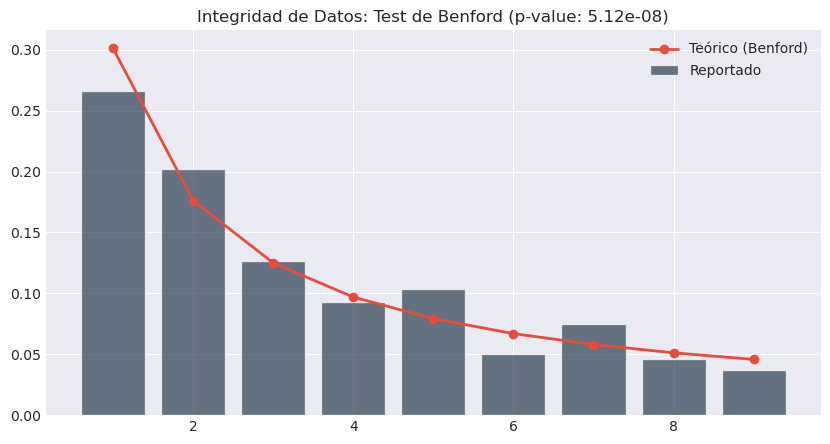

ALERTA: Los datos presentan evidencia estadística de manipulación o estimación manual.
INFO: p-valor 5.118926842628549e-08


In [211]:
def benford_audit(series):
    # Extracción del primer dígito significativo
    first_digits = series.astype(str).str.lstrip('0').str[0].astype(int)
    first_digits = first_digits[first_digits > 0]

    # Frecuencias observadas vs esperadas
    obs_counts = first_digits.value_counts().sort_index()
    total = obs_counts.sum()
    expected_probs = np.log10(1 + 1 / np.arange(1, 10))
    exp_counts = expected_probs * total

    # Test estadístico de Chi-Cuadrado
    chi2, p_val = chisquare(obs_counts, f_exp=exp_counts)

    # Visualización
    plt.figure(figsize=(10, 5))
    plt.bar(np.arange(1, 10), obs_counts / total, label='Reportado', alpha=0.7, color='#2c3e50')
    plt.plot(np.arange(1, 10), expected_probs, color='#e74c3c', marker='o', linewidth=2, label='Teórico (Benford)')
    plt.title(f'Integridad de Datos: Test de Benford (p-value: {p_val:.2e})')
    plt.legend()
    plt.show()

    return p_val


p_value = benford_audit(df['VOLUMEN_m3_ano'])
if p_value < 0.05:
    print("ALERTA: Los datos presentan evidencia estadística de manipulación o estimación manual.")
    print(f"INFO: p-valor {p_value}")

En un conjunto de datos medidos por instrumentos reales, el último dígito (0-9) debe distribuirse uniformemente (10% de probabilidad cada uno). Los seres humanos, al estimar o inventar cifras, tienen un sesgo cognitivo masivo hacia el redondeo en 0 y 5. Este test revela qué porcentaje del censo son estimaciones

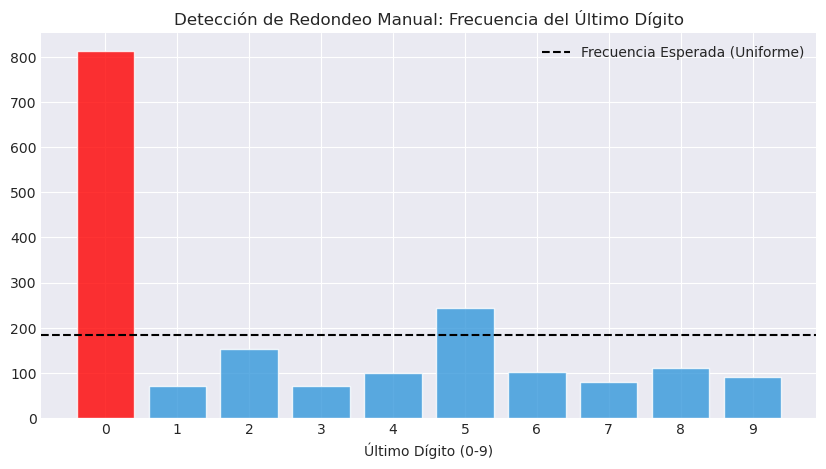

Sobre-representación del dígito '0': +342.5% (Indicio de redondeo masivo)


In [212]:
def terminal_digit_analysis(series):
    # Extraer el último dígito entero
    last_digits = series.dropna().apply(lambda x: int(str(int(x))[-1]))

    # Conteo
    counts = last_digits.value_counts().sort_index()

    # Visualización
    plt.figure(figsize=(10, 5))
    colors = ['red' if c > counts.mean() + counts.std() else '#3498db' for c in counts]
    plt.bar(counts.index, counts.values, color=colors, alpha=0.8)
    plt.axhline(y=len(series) / 10, color='black', linestyle='--', label='Frecuencia Esperada (Uniforme)')
    plt.title('Detección de Redondeo Manual: Frecuencia del Último Dígito')
    plt.xticks(range(10))
    plt.xlabel('Último Dígito (0-9)')
    plt.legend()
    plt.show()

    # Cálculo de exceso de ceros
    zero_bias = (counts[0] - (len(series) / 10)) / (len(series) / 10) * 100
    print(f"Sobre-representación del dígito '0': +{zero_bias:.1f}% (Indicio de redondeo masivo)")


terminal_digit_analysis(df['VOLUMEN_m3_ano'])

Hemos detectado que muchos volúmenes son múltiplos exactos de 365. Esto indica que no se está midiendo el vertido real, sino que se toma un valor teórico diario (ej. 100 m3/día) y se multiplica por los días del año. Este snippet identifica automáticamente estas Fórmulas de Excel disfrazadas de Datos.

In [213]:
def spreadsheet_artifact_detector(series):
    # Verificar si el volumen es divisible por 365 (con margen de error mínimo)
    is_365_multiple = (series % 365 == 0) & (series > 0)

    # Identificar los patrones más comunes
    artifacts = series[is_365_multiple].value_counts().head(5)

    print(f"Total de registros generados por fórmula (X * 365): {is_365_multiple.sum()}")
    print("\nPatrones de repetición más comunes (Volumen Anual -> Estimación Diaria):")
    for vol, count in artifacts.items():
        daily = vol / 365
        print(f"  - {vol:,.0f} m3/año ({count} casos) -> Equivale a exactamente {daily:.0f} m3/día")


spreadsheet_artifact_detector(df['VOLUMEN_m3_ano'])

Total de registros generados por fórmula (X * 365): 528

Patrones de repetición más comunes (Volumen Anual -> Estimación Diaria):
  - 365 m3/año (57 casos) -> Equivale a exactamente 1 m3/día
  - 730 m3/año (27 casos) -> Equivale a exactamente 2 m3/día
  - 1,095 m3/año (20 casos) -> Equivale a exactamente 3 m3/día
  - 7,300 m3/año (19 casos) -> Equivale a exactamente 20 m3/día
  - 3,650 m3/año (18 casos) -> Equivale a exactamente 10 m3/día


Con 1830 registros esto indica que 1/3 de los registros son meras estimaciones y no datos reales

Procedemos a marcar esas filas como low fidelity porque si son calculadas es más improbable que reporten un exceso o accidente.

Se puede decidir si profundizar sobre esta vía o no

In [214]:
df['LOW_FIDELITY'] = (df['VOLUMEN_m3_ano'] % 365 == 0) & (df['VOLUMEN_m3_ano'] > 0)

In [215]:
df

,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,tipo_titular,log_vol,LOW_FIDELITY
0,DROMEN GESTORES Y CONSULTORES (VIV. UNIFAMILIAR),"DROMEN GESTORES Y CONSULTORES, S.L.",ADRADA (LA),AVILA,358144.0,4460601.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,231.0,CATEGORÍA I,AV-0006/2020,J,5.446737,False
1,PIZZERIA-RESTAURANTE PUENTE MOCHA,PERSONA FÍSICA,ADRADA (LA),AVILA,358290.0,4459633.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,1188.0,CATEGORÍA I,AV-0049/1999,F,7.080868,False
2,CENTRO HÍPICO LA ESPUELA,"CORPORACIÓN RILUMI, S.L.",ADRADA (LA),AVILA,358288.0,4459174.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,3650.0,CATEGORÍA I,AV-0041/2015,J,8.202756,True
3,EDAR LA ADRADA,AYUNTAMIENTO DE LA ADRADA,ADRADA (LA),AVILA,359461.0,4460939.0,ARROYO FRANQUILLO,URBANO O ASIMILABLE,2.000-10.000 h-e,1193058.0,CATEGORÍA I,AV-0053/2014,A,13.992031,False
4,PERSONA FÍSICA (VIVIENDAS),PERSONA FÍSICA,ADRADA (LA),AVILA,357353.0,4461118.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,102.0,CATEGORÍA I,AV-0041/2017,F,4.634729,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1830,CANTERA YEPES LAFARGE CEMENTOS (ASEOS),"LAFARGE CEMENTOS, S.A.U.",YEPES,TOLEDO,443626.0,4419156.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,312.0,CATEGORÍA I,AV-0054/2000,J,5.746203,False
1831,HOSTAL-RESTAURANTE EL RINCON - CASA MARCOS,"HOSTAL-RESTAURANTE EL RINCON, S.L.",YEPES,TOLEDO,436468.0,4421408.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,1424.0,CATEGORÍA I,AV-0113/2003,J,7.261927,False
1832,FABRICA CEMENTO CASTILLEJO CEMEX (ASEOS),"CEMEX ESPAÑA OPERACIONES, S.L.U.",YEPES,TOLEDO,436365.0,4420347.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,5840.0,CATEGORÍA I,AV-0022/1996,J,8.672657,True
1833,TALLER YUNCLER MOTOR (ASEOS),"YUNCLER MOTOR, S.L.",YUNCLER,TOLEDO,423618.0,4435868.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,182.0,CATEGORÍA I,AV-0024/2016,J,5.209486,False


In [216]:
df[df['LOW_FIDELITY']].groupby('tipo_titular').count()

,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,log_vol,LOW_FIDELITY
tipo_titular,,,,,,,,,,,,,,
A,236,236,236,236,236,236,236,236,236,236,236,236,236,236
F,70,70,70,70,70,70,70,70,70,70,70,70,70,70
J,222,222,222,222,222,222,222,222,222,222,222,222,222,222


Tanto ayuntamientos como agrupaciones privadas o personas físicas caen en esta catogoría

In [217]:
print(df.groupby('PROVINCIA').count()['NOMBRE_VERTIDO'])
print(df[df['LOW_FIDELITY']].groupby('PROVINCIA').count()['NOMBRE_VERTIDO'])

df[df['LOW_FIDELITY']].groupby('PROVINCIA').count()['NOMBRE_VERTIDO'] / df.groupby('PROVINCIA').count()[
    'NOMBRE_VERTIDO']

PROVINCIA
AVILA          217
BADAJOZ          2
CACERES        375
CUENCA          48
GUADALAJARA    203
MADRID         585
SALAMANCA       46
TERUEL           5
TOLEDO         354
Name: NOMBRE_VERTIDO, dtype: int64
PROVINCIA
AVILA           29
CACERES        118
CUENCA           8
GUADALAJARA     55
MADRID         177
SALAMANCA        5
TERUEL           1
TOLEDO         135
Name: NOMBRE_VERTIDO, dtype: int64


PROVINCIA
AVILA          0.133641
BADAJOZ             NaN
CACERES        0.314667
CUENCA         0.166667
GUADALAJARA    0.270936
MADRID         0.302564
SALAMANCA      0.108696
TERUEL         0.200000
TOLEDO         0.381356
Name: NOMBRE_VERTIDO, dtype: float64

## Aislamiento de ouliers

Utilizamos un algoritmo de Isolation Forest para detectar outliers multidimensionales. A diferencia de un simple filtro por volumen, este modelo cruza la ubicación (UTM X, Y) con el volumen. Identifica vertidos que son anormales para su ubicación o magnitud relativa, aislando casos como Persona Física con volúmenes industriales.


In [275]:
features = df[['UTM_X', 'UTM_Y', 'log_vol']].fillna(0)

# Configuración del modelo: Contaminación estimada del 1% (casos extremos)
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=69420)
df['anomaly_score'] = iso_forest.fit_predict(features)

# Filtrado de anomalías (score = -1)
anomalies = df[df['anomaly_score'] == -1].sort_values('VOLUMEN_m3_ano', ascending=False)

print("Top 5 Anomalías detectadas por el algoritmo:")
display(anomalies[['MUNICIPIO', 'TITULAR', 'VOLUMEN_m3_ano', 'NATURALEZA_VERTIDO']].head(10))

Top 5 Anomalías detectadas por el algoritmo:


,MUNICIPIO,TITULAR,VOLUMEN_m3_ano,NATURALEZA_VERTIDO
668,ANGUITA,PERSONA FÍSICA,15768000.0,INDUSTRIAL
266,CACERES,AYUNTAMIENTO DE CÁCERES,9896341.0,URBANO O ASIMILABLE
217,SAN VICENTE DE ALCANTARA,AYUNTAMIENTO DE SAN VICENTE DE ALCANTARA,680000.0,URBANO O ASIMILABLE
549,VALENCIA DE ALCANTARA,AYUNTAMIENTO DE VALENCIA DE ALCANTARA,655106.0,URBANO O ASIMILABLE
240,ALCUESCAR,AYUNTAMIENTO DE ALCUESCAR,306089.0,URBANO O ASIMILABLE
435,MONTANCHEZ,AYUNTAMIENTO DE MONTANCHEZ,218270.0,URBANO O ASIMILABLE
543,VALDEFUENTES,AYUNTAMIENTO DE VALDEFUENTES,156950.0,URBANO O ASIMILABLE
592,ZARZA DE MONTANCHEZ,AYUNTAMIENTO DE ZARZA DE MONTANCHEZ,122275.0,URBANO O ASIMILABLE
371,HERRERA DE ALCANTARA,AYUNTAMIENTO DE HERRERA DE ALCANTARA,47700.0,URBANO O ASIMILABLE
311,CEDILLO,AYUNTAMIENTO DE CEDILLO,45000.0,URBANO O ASIMILABLE


Antes de juzgar lo anormal, debemos definir rigurosamente lo normal. Utilizando los inliers (datos no anómalos) clasificados por el algoritmo Isolation Forest previo, construimos el perfil del vertido estándar. Cualquier desviación futura se medirá contra esta Línea Base Operativa.

Aunque también sea dicho, destaca bastante la persona física con semejante volumen de vertidos al año, aunque sea de tipo industrial.
Que aparezcan los ayuntamientos es relativamente normal ya que suelen ser los que más vierten respecto a los demás

Si eliminarmos a los ayuntamientos de la ecuación tenemos

In [282]:
anomalies[(anomalies['tipo_titular'] != 'A')].head()

,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,tipo_titular,log_vol,LOW_FIDELITY,anomaly_score,lof_score,lof_negative_factor,spatial_cluster,km_rio,dist_al_rio,TITULAR_NORM,MUNICIPIO_NORM
668,PERSONA FÍSICA (PISCIFACTORÍA LOS BATANES),PERSONA FÍSICA,ANGUITA,GUADALAJARA,553928.0,4542873.0,RÍO TAJUÑA,INDUSTRIAL,CLASE 3 Piscifactoría,15768000.00,CATEGORÍA I,AV-0019/2005,F,16.573493,True,-1,1,-1.068754,-1,294809.936053,27054.082223,PERSONA FÍSICA,ANGUITA
547,"E.S. CTRA. N-521, KM 151,400","CASARES DAZA, S.L.",VALENCIA DE ALCANTARA,CACERES,129635.0,4364015.0,ARROYO LAS CARRIZAS,URBANO O ASIMILABLE,<2.000 h-e,3672.00,CATEGORÍA I,AV-0091/1996,J,8.208764,False,-1,1,-1.255937,-1,180162.376905,122452.498112,"CASARES DAZA, S.L.",VALENCIA DE ALCANTARA
548,PLANTA AGUA MINERAL SIERRA FRÍA (ASEOS),"CHUMACERO, S.A.",VALENCIA DE ALCANTARA,CACERES,129387.0,4367051.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,1898.00,CATEGORÍA I,AV-0101/2001,J,7.549083,False,-1,1,-1.248726,-1,180162.376905,121468.940566,"CHUMACERO, S.A.",VALENCIA DE ALCANTARA
310,CENTRAL HIDRÁULICA DE CEDILLO (ASEOS CENTRAL),"IBERDROLA GENERACION, S.A.U.",CEDILLO,CACERES,110450.0,4400250.0,RÍO TAJO,URBANO O ASIMILABLE,<2.000 h-e,770.88,CATEGORÍA I,AV-0138/2003,J,6.648829,False,-1,1,-1.269712,12,180162.376905,131629.870135,"IBERDROLA GENERACION, S.A.U.",CEDILLO
307,CENTRAL HIDRÁULICA DE CEDILLO (ASEOS PLANTA TU...,"IBERDROLA GENERACION, S.A.U.",CEDILLO,CACERES,110502.0,4400363.0,RÍO TAJO,URBANO O ASIMILABLE,<2.000 h-e,274.00,CATEGORÍA I,AV-0146/2004,J,5.616771,False,-1,1,-1.269358,12,180162.376905,131566.247918,"IBERDROLA GENERACION, S.A.U.",CEDILLO


Vemos que Iberdrola destaca sobre los demás, así como una piscifactoría. Si fueramos el SEPRONA podríamos indagar algo más a ver qué es lo que lo hacen destacar

Vamos a aplicar explicabilidad con SHAP porque isolation forest es una caja negra por defecto. También podríamos correr una análisis de z-score, pero esa técnica fue más utilizada en el análisis de contaminantes, por lo que en este cuaderno vamos a seguir por esta linea

In [285]:
explainer = shap.TreeExplainer(iso_forest)

Calculamos los valores SHAP para las anomalías detectadas

In [286]:
anomalias_features = features.loc[df['anomaly_score'] == -1]
shap_values = explainer.shap_values(anomalias_features)

Vamos a ver qué es lo que define una anomalía

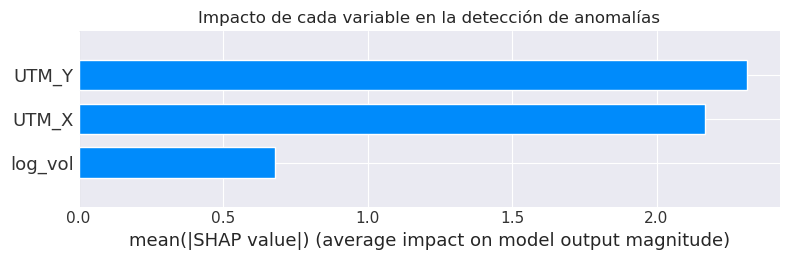

In [287]:
plt.title("Impacto de cada variable en la detección de anomalías")
shap.summary_plot(shap_values, anomalias_features, plot_type="bar")

Expliquemos por ejemplo, por qué el primero de la lista es una anomalía

Explicando anomalía: PERSONA FÍSICA


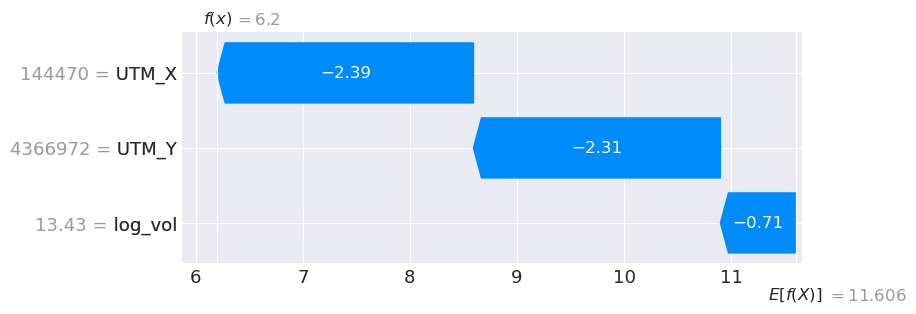

In [288]:
index_top_anomaly = 0  # El primero de la lista de anomalías
print(f"Explicando anomalía: {anomalies.iloc[index_top_anomaly]['TITULAR']}")

# El waterfall plot muestra cómo cada feature empuja el score hacia 'anomalía'
shap.plots.waterfall(shap.Explanation(values=shap_values[index_top_anomaly],
                                      base_values=explainer.expected_value,
                                      data=anomalias_features.iloc[index_top_anomaly],
                                      feature_names=features.columns))

Vemos que es un outlier geográfico, posiblemente un vertido donde no se esperaría nada

Podemos generar un mapa de anomalías

✅ Leyendo geometría del río desde: /tmp/pycharm_project_992/data/datasets/raw/linestring_tajo.csv


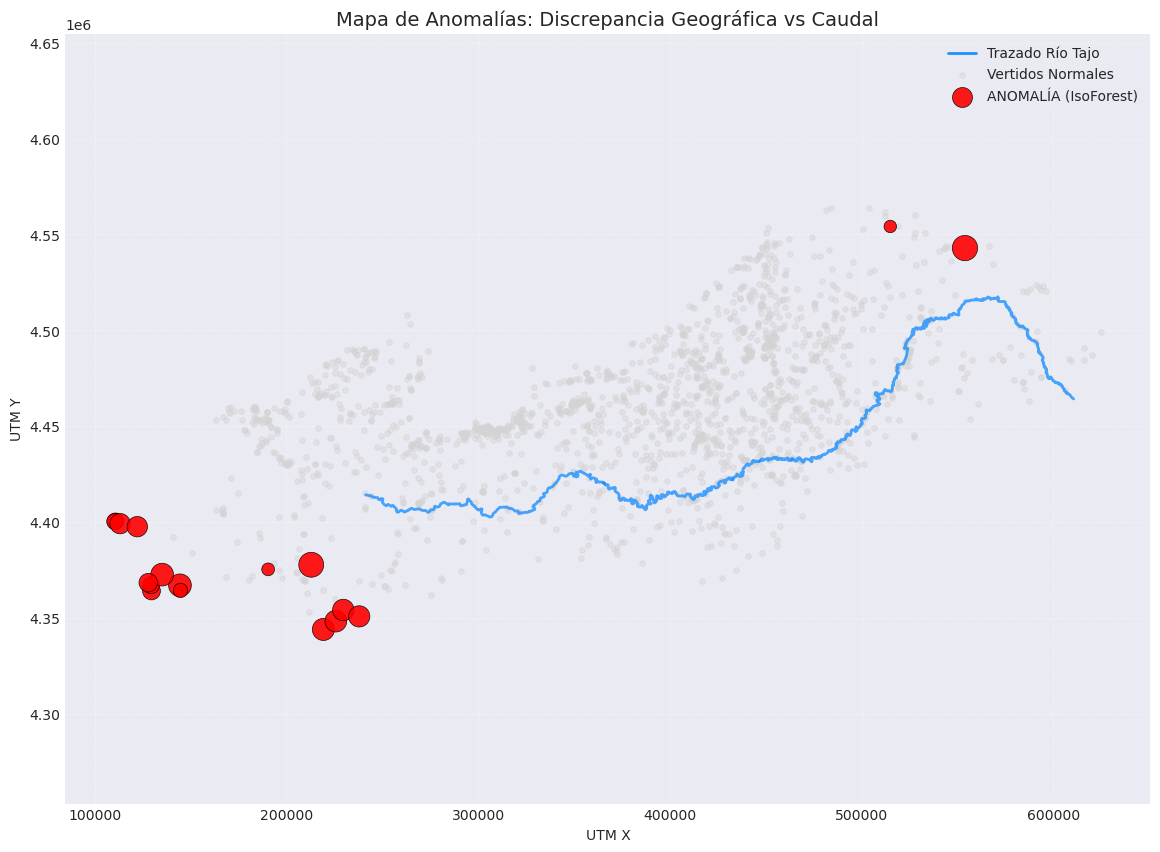

In [295]:
ruta_rio = '/tmp/pycharm_project_992/data/datasets/raw/linestring_tajo.csv'

plt.figure(figsize=(14, 10))

# PINTAR EL RÍO (Capa inferior)
if os.path.exists(ruta_rio):
    print(f"✅ Leyendo geometría del río desde: {ruta_rio}")
    try:
        df_rio = pd.read_csv(ruta_rio)

        # Iteramos sobre la columna 'geometry' que contiene el MULTILINESTRING
        for geom_txt in df_rio['geometry']:
            try:
                # Convertimos texto WKT a objeto geométrico
                geom = wkt.loads(geom_txt)

                # Extraemos coordenadas X, Y para pintar
                if geom.geom_type == 'MultiLineString':
                    for line in geom.geoms:
                        x, y = line.xy
                        plt.plot(x, y, color='dodgerblue', linewidth=2, alpha=0.8)
                elif geom.geom_type == 'LineString':
                    x, y = geom.xy
                    plt.plot(x, y, color='dodgerblue', linewidth=2, alpha=0.8)
            except Exception as e:
                pass  # Si alguna fila está corrupta, la saltamos

        # Truco para que salga en la leyenda una sola vez
        plt.plot([], [], color='dodgerblue', linewidth=2, label='Trazado Río Tajo')

    except Exception as e:
        print(f"Error procesando el archivo del río: {e}")
else:
    print(f"El archivo {ruta_rio} no existe. Se pintarán solo los puntos.")

# PINTAR VERTIDOS (Capa superior)
# Normales (Gris)
normales = df[df['anomaly_score'] == 1]
plt.scatter(normales['UTM_X'], normales['UTM_Y'],
            c='lightgray', s=15, alpha=0.4, label='Vertidos Normales')

# Anomalías (Rojo)
anomalos = df[df['anomaly_score'] == -1]
plt.scatter(anomalos['UTM_X'], anomalos['UTM_Y'],
            c='red',
            s=anomalos['log_vol'] * 20,  # Tamaño proporcional al volumen
            edgecolors='black', linewidth=0.5,
            alpha=0.9,
            label='ANOMALÍA (IsoForest)')

# --- ESTÉTICA ---
plt.title("Mapa de Anomalías: Discrepancia Geográfica vs Caudal", fontsize=14)
plt.xlabel("UTM X")
plt.ylabel("UTM Y")
plt.legend(loc='upper right')
plt.axis('equal')  # CLAVE: Para que el mapa no salga estirado
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

Ahora entendemos mejor ese cluster de anomalías. Primero que están muy lejos del río principal.
En el Huso 30 (España peninsular), la coordenada X suele ir de ~200.000 (Oeste) a ~800.000 (Este). Un valor de 10.000 o 20.000 está casi fuera del mapa, o muy pegado al borde del huso (frontera con Portugal o cambio de zona 29/30).

Hagamos un poco de zoom en la zona a ver qué puede estar pasando

In [304]:
filtro_fantasma = (
        (df['UTM_X'] > 0) & (df['UTM_X'] < 150000) &  # <--- CAMBIO CLAVE AQUÍ
        (df['UTM_Y'] > 4300000) & (df['UTM_Y'] < 4600000)  # Amplío un poco margen Y por seguridad
)

investigacion = df[filtro_fantasma].sort_values('UTM_X')

print(f"Se han detectado {len(investigacion)} expedientes en el extremo Oeste (Frontera).")

if not investigacion.empty:
    print("\n--- MUESTRA DE LOS SOSPECHOSOS (Top 10 más al Oeste) ---")
    cols_clave = ['REF_EXPEDIENTE', 'MUNICIPIO', 'PROVINCIA', 'TITULAR', 'MEDIO_RECEPTOR', 'UTM_X', 'UTM_Y',
                  'VOLUMEN_m3_ano']
    # Filtramos columnas que existan realmente en tu DF
    cols_existentes = [c for c in cols_clave if c in df.columns]

    display(investigacion[cols_existentes].head(10))

    print("\n--- DÓNDE DICEN QUE VIERTEN ---")
    print(investigacion['MEDIO_RECEPTOR'].value_counts().head(5))

    print("\n--- EN QUÉ MUNICIPIOS ESTÁN ---")
    print(investigacion['MUNICIPIO'].value_counts().head(5))
else:
    print("Sigue sin salir nada. Verifica si 'UTM_X' es la columna correcta.")

Se han detectado 13 expedientes en el extremo Oeste (Frontera).

--- MUESTRA DE LOS SOSPECHOSOS (Top 10 más al Oeste) ---


,REF_EXPEDIENTE,MUNICIPIO,PROVINCIA,TITULAR,MEDIO_RECEPTOR,UTM_X,UTM_Y,VOLUMEN_m3_ano
310,AV-0138/2003,CEDILLO,CACERES,"IBERDROLA GENERACION, S.A.U.",RÍO TAJO,110450.0,4400250.0,770.88
307,AV-0146/2004,CEDILLO,CACERES,"IBERDROLA GENERACION, S.A.U.",RÍO TAJO,110502.0,4400363.0,274.00
309,AV-0090/2012,CEDILLO,CACERES,AYUNTAMIENTO DE CEDILLO,TERRENO,110850.0,4400410.0,1095.00
308,AV-0566/1990,CEDILLO,CACERES,"IBERDROLA GENERACION, S.A.U.",TERRENO,111638.0,4399969.0,1095.00
311,AV-0085/2012,CEDILLO,CACERES,AYUNTAMIENTO DE CEDILLO,REGATO PUEBLO,113258.0,4399132.0,45000.00
371,AV-0073/2014,HERRERA DE ALCANTARA,CACERES,AYUNTAMIENTO DE HERRERA DE ALCANTARA,RÍO TAJO,122219.0,4397554.0,47700.00
550,AV-0050/2015,VALENCIA DE ALCANTARA,CACERES,AYUNTAMIENTO DE VALENCIA DE ALCANTARA,ARROYO INNOMINADO,127945.0,4368359.0,7300.00
548,AV-0101/2001,VALENCIA DE ALCANTARA,CACERES,"CHUMACERO, S.A.",TERRENO,129387.0,4367051.0,1898.00
547,AV-0091/1996,VALENCIA DE ALCANTARA,CACERES,"CASARES DAZA, S.L.",ARROYO LAS CARRIZAS,129635.0,4364015.0,3672.00
549,AV-0080/2023,VALENCIA DE ALCANTARA,CACERES,AYUNTAMIENTO DE VALENCIA DE ALCANTARA,RIVERA AVID,135180.0,4372550.0,655106.00



--- DÓNDE DICEN QUE VIERTEN ---
MEDIO_RECEPTOR
TERRENO                4
RÍO TAJO               3
REGATO PUEBLO          1
ARROYO INNOMINADO      1
ARROYO LAS CARRIZAS    1
Name: count, dtype: int64

--- EN QUÉ MUNICIPIOS ESTÁN ---
MUNICIPIO
CEDILLO                     5
VALENCIA DE ALCANTARA       4
SAN VICENTE DE ALCANTARA    2
HERRERA DE ALCANTARA        1
CARBAJO                     1
Name: count, dtype: int64


Vemos que no hay nada raro en los datos. Nada más son casos que están muy aislados del resto. Recordemos que el mayor grupo está en Madrid y el menor en Badajoz. Lo cual encaja de por qué Isolation Forest ha conseguido aislarlos. Están en la frontera y hay muy pocos registros aquí

Aprovechamos para ver los pueblos más al oeste (pegados a portugal)

In [301]:
# Ordenamos por UTM_X ascendente (los menores primero) y cogemos los 10 primeros
extremo_oeste = df.sort_values('UTM_X', ascending=True).head(10)

print("--- EXTREMO OESTE (CÁCERES / FRONTERA) ---")
# Imprimimos columna a columna para asegurarnos de que se ve
for i, row in extremo_oeste.iterrows():
    # Ajusta los nombres de columnas si en tu CSV son distintos (ej: 'Municipio' vs 'MUNICIPIO')
    muni = row.get('MUNICIPIO', 'Desconocido')
    prov = row.get('PROVINCIA', 'Desconocido')
    rio = row.get('MEDIO_RECEPTOR', row.get('rio', 'Desconocido'))
    x = row['UTM_X']

    print(f"{muni} ({prov}) | Río: {rio} | UTM_X: {x:.0f}")

--- EXTREMO OESTE (CÁCERES / FRONTERA) ---
CEDILLO (CACERES) | Río: RÍO TAJO | UTM_X: 110450
CEDILLO (CACERES) | Río: RÍO TAJO | UTM_X: 110502
CEDILLO (CACERES) | Río: TERRENO | UTM_X: 110850
CEDILLO (CACERES) | Río: TERRENO | UTM_X: 111638
CEDILLO (CACERES) | Río: REGATO PUEBLO | UTM_X: 113258
HERRERA DE ALCANTARA (CACERES) | Río: RÍO TAJO | UTM_X: 122219
VALENCIA DE ALCANTARA (CACERES) | Río: ARROYO INNOMINADO | UTM_X: 127945
VALENCIA DE ALCANTARA (CACERES) | Río: TERRENO | UTM_X: 129387
VALENCIA DE ALCANTARA (CACERES) | Río: ARROYO LAS CARRIZAS | UTM_X: 129635
VALENCIA DE ALCANTARA (CACERES) | Río: RIVERA AVID | UTM_X: 135180


Ahora vemos como se distribuye el tamaño del vertido normal/esperable respecto a las anomalías

=== PERFIL OPERATIVO: VERTIDO ESTÁNDAR (BASELINE) ===
Volumen Mediano (Típico):      2395.00 m3/año
Umbral Superior (95% casos):   934957.75 m3/año
Moda - Naturaleza:             URBANO O ASIMILABLE
Moda - Medio Receptor:         TERRENO


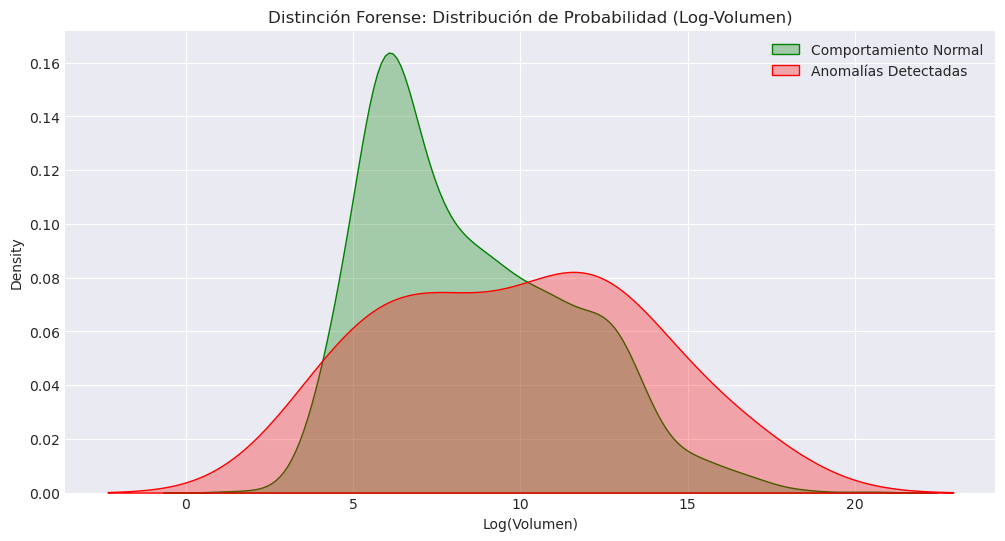

In [311]:
normal_population = df[df['anomaly_score'] == 1]  # Inliers
anomalous_population = df[df['anomaly_score'] == -1]  # Outliers

print("=== PERFIL OPERATIVO: VERTIDO ESTÁNDAR (BASELINE) ===")
stats = normal_population['VOLUMEN_m3_ano'].describe(percentiles=[0.25, 0.5, 0.75, 0.95])

print(f"Volumen Mediano (Típico):      {stats['50%']:.2f} m3/año")
print(f"Umbral Superior (95% casos):   {stats['95%']:.2f} m3/año")
print(f"Moda - Naturaleza:             {normal_population['NATURALEZA_VERTIDO'].mode()[0]}")
print(f"Moda - Medio Receptor:         {normal_population['MEDIO_RECEPTOR'].mode()[0]}")

# Visualización comparativa: Normalidad vs Anomalía
plt.figure(figsize=(12, 6))
sns.kdeplot(np.log1p(normal_population['VOLUMEN_m3_ano']), fill=True, color='green', label='Comportamiento Normal',
            alpha=0.3)
sns.kdeplot(np.log1p(anomalous_population['VOLUMEN_m3_ano']), fill=True, color='red', label='Anomalías Detectadas',
            alpha=0.3)
plt.title('Distinción Forense: Distribución de Probabilidad (Log-Volumen)')
plt.xlabel('Log(Volumen)')
plt.legend()
plt.show()

Vemos que el comportamiento normal parece seguir dos distribuciones sumadas. Con un pico muy fuerte en vertidos de alrededor de 5-7 cifras (m3) comparado con las anomalías que siguen una distribución más plana

Tengo una teoría sobre la contribución de Madrid al pico. Verifequemosla

=== PERFIL OPERATIVO: VERTIDO ESTÁNDAR (BASELINE) ===
Volumen Mediano (Típico Madrid):      4992.60 m3/año
Umbral Superior (95% casos Madrid):   4541129.60 m3/año
Moda - Naturaleza Madrid:             URBANO O ASIMILABLE
Moda - Medio Receptor Madrid:         TERRENO


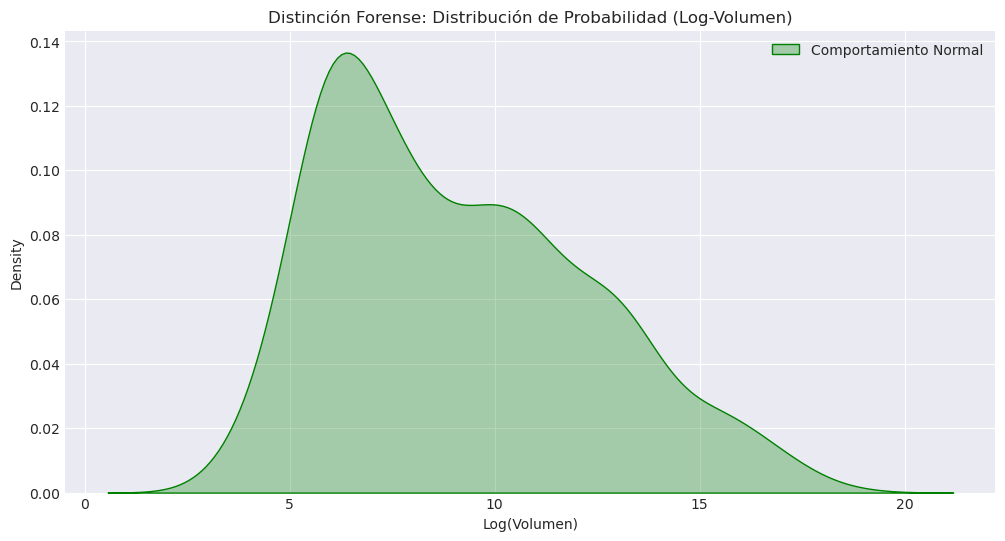

In [314]:
# Filtramos para quedarnos con Madrid
tmp = df[df['PROVINCIA'] == 'MADRID']

normal_population_mad = tmp[tmp['anomaly_score'] == 1]  # Inliers
anomalous_population_mad = tmp[tmp['anomaly_score'] == -1]  # Outliers

print("=== PERFIL OPERATIVO: VERTIDO ESTÁNDAR (BASELINE) ===")
stats = normal_population_mad['VOLUMEN_m3_ano'].describe(percentiles=[0.25, 0.5, 0.75, 0.95])

print(f"Volumen Mediano (Típico Madrid):      {stats['50%']:.2f} m3/año")
print(f"Umbral Superior (95% casos Madrid):   {stats['95%']:.2f} m3/año")
print(f"Moda - Naturaleza Madrid:             {normal_population_mad['NATURALEZA_VERTIDO'].mode()[0]}")
print(f"Moda - Medio Receptor Madrid:         {normal_population_mad['MEDIO_RECEPTOR'].mode()[0]}")

# Visualización comparativa: Normalidad vs Anomalía
plt.figure(figsize=(12, 6))
sns.kdeplot(np.log1p(normal_population_mad['VOLUMEN_m3_ano']), fill=True, color='green', label='Comportamiento Normal',
            alpha=0.3)
sns.kdeplot(np.log1p(anomalous_population_mad['VOLUMEN_m3_ano']), fill=True, color='red', label='Anomalías Detectadas',
            alpha=0.3)
plt.title('Distinción Forense: Distribución de Probabilidad (Log-Volumen)')
plt.xlabel('Log(Volumen)')
plt.legend()
plt.show()

Vemos que Madrid no tiene ni si quiera una gráfica de anomalías. Lo cual nos dice mucho sobre la cantidad de puntos que rodean a Madrid, que es lógico por el tamaño de la población

Si superponemos las gráficas tenemos:

Volumen Mediano (Típico Madrid):      4992.60 m3/año
Umbral Superior (95% casos Madrid):   4541129.60 m3/año
Moda - Naturaleza Madrid:             URBANO O ASIMILABLE
Moda - Medio Receptor Madrid:         TERRENO
Volumen Mediano (Típico):      4992.60 m3/año
Umbral Superior (95% casos):   4541129.60 m3/año
Moda - Naturaleza:             URBANO O ASIMILABLE
Moda - Medio Receptor:         TERRENO


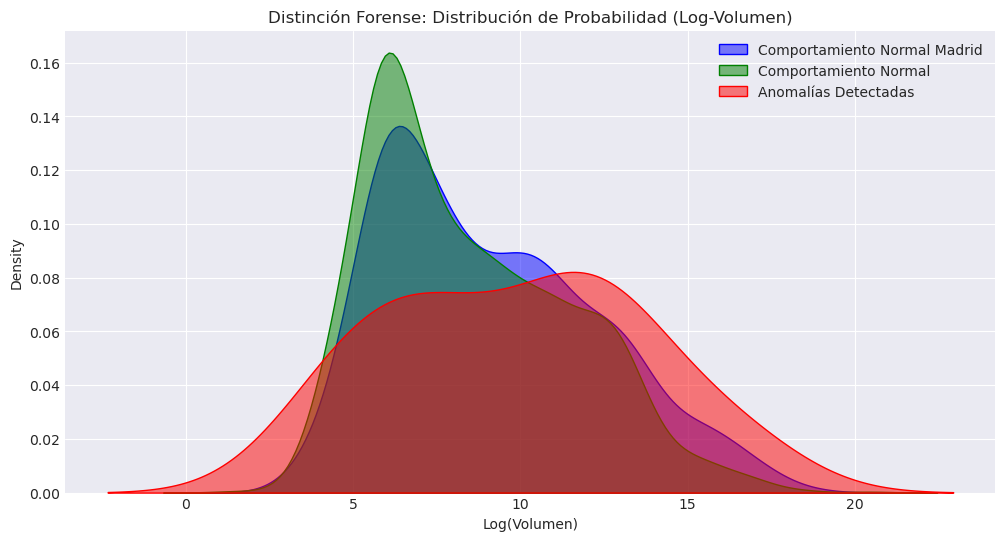

In [316]:
stats = normal_population_mad['VOLUMEN_m3_ano'].describe(percentiles=[0.25, 0.5, 0.75, 0.95])

print(f"Volumen Mediano (Típico Madrid):      {stats['50%']:.2f} m3/año")
print(f"Umbral Superior (95% casos Madrid):   {stats['95%']:.2f} m3/año")
print(f"Moda - Naturaleza Madrid:             {normal_population_mad['NATURALEZA_VERTIDO'].mode()[0]}")
print(f"Moda - Medio Receptor Madrid:         {normal_population_mad['MEDIO_RECEPTOR'].mode()[0]}")

# Visualización Madrid
plt.figure(figsize=(12, 6))
sns.kdeplot(np.log1p(normal_population_mad['VOLUMEN_m3_ano']), fill=True, color='blue',
            label='Comportamiento Normal Madrid', alpha=0.5)
sns.kdeplot(np.log1p(anomalous_population_mad['VOLUMEN_m3_ano']), fill=True, color='purple',
            label='Anomalías Detectadas', alpha=0.5)

print(f"Volumen Mediano (Típico):      {stats['50%']:.2f} m3/año")
print(f"Umbral Superior (95% casos):   {stats['95%']:.2f} m3/año")
print(f"Moda - Naturaleza:             {normal_population['NATURALEZA_VERTIDO'].mode()[0]}")
print(f"Moda - Medio Receptor:         {normal_population['MEDIO_RECEPTOR'].mode()[0]}")

# Visualización resto
sns.kdeplot(np.log1p(normal_population['VOLUMEN_m3_ano']), fill=True, color='green', label='Comportamiento Normal',
            alpha=0.5)
sns.kdeplot(np.log1p(anomalous_population['VOLUMEN_m3_ano']), fill=True, color='red', label='Anomalías Detectadas',
            alpha=0.5)
plt.title('Distinción Forense: Distribución de Probabilidad (Log-Volumen)')
plt.xlabel('Log(Volumen)')
plt.legend()
plt.show()

Esto confirma completamente la toería. Según el isolation forest, el vertido más normal es el vertido en Madrid. Las gráficas prácticamente encajan a la perfección

Podríamos continuar entrenando un nuevo isolation forest sin Madrid, pero vamos a explorar otras técnicas, ya que esto al final es un trabajo académico

A continuación, a diferencia del Isolation Forest (que busca anomalías globales intentando aislar de forma aleatoria los puntos), el LOF (Local Outlier Factor) busca desviaciones de densidad local. Detecta: Un vertido que, aunque no sea enorme en volumen absoluto, es sospechosamente grande comparado con sus vecinos geográficos. Es ideal para encontrar industrias ocultas en zonas rurales o residenciales.

In [220]:
# Configuración: Analizamos la densidad local con 20 vecinos más cercanos
# Contaminación 1%: Buscamos solo las desviaciones más flagrantes
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)

# Features: Coordenadas y Volumen
features_lof = df[['UTM_X', 'UTM_Y', 'log_vol']].fillna(0)
df['lof_score'] = lof.fit_predict(features_lof)
df['lof_negative_factor'] = lof.negative_outlier_factor_  # Cuanto más negativo, más anómalo

# Extracción de Anomalías Contextuales
context_anomalies = df[df['lof_score'] == -1].sort_values('lof_negative_factor')

print("=== ANOMALÍAS CONTEXTUALES (LOF) ===")
print("Objetivos que destacan inusualmente respecto a su entorno inmediato:")
display(context_anomalies[['MUNICIPIO', 'TITULAR', 'VOLUMEN_m3_ano', 'lof_negative_factor']].head(5))

=== ANOMALÍAS CONTEXTUALES (LOF) ===
Objetivos que destacan inusualmente respecto a su entorno inmediato:


,MUNICIPIO,TITULAR,VOLUMEN_m3_ano,lof_negative_factor
136,CEPEDA LA MORA,PERSONA FÍSICA,130.0,-2.266951
1455,MEMBRIBE DE LA SIERRA,AYUNTAMIENTO DE MEMBRIBE DE LA SIERRA,6420.0,-2.193227
1677,OROPESA,INFRAESTRUCTURAS DEL AGUA DE CASTILLA-LA MANCHA,61000.0,-2.148540
1678,OROPESA,PERSONA FÍSICA,10000.0,-2.034373
216,VILLAREJO DEL VALLE,MINISTERIO PARA LA TRANSICIÓN ECOLÓGICA Y RETO...,5132.5,-2.003873


Vamos a excluir a las entidades públicas de la búsqueda

In [318]:
df

,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,tipo_titular,log_vol,LOW_FIDELITY,anomaly_score,lof_score,lof_negative_factor,spatial_cluster,km_rio,dist_al_rio,TITULAR_NORM,MUNICIPIO_NORM
0,DROMEN GESTORES Y CONSULTORES (VIV. UNIFAMILIAR),"DROMEN GESTORES Y CONSULTORES, S.L.",ADRADA (LA),AVILA,358144.0,4460601.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,231.0,CATEGORÍA I,AV-0006/2020,J,5.446737,False,1,1,-1.210545,0,18861.637670,34423.904561,"DROMEN GESTORES Y CONSULTORES, S.L.",ADRADA (LA)
1,PIZZERIA-RESTAURANTE PUENTE MOCHA,PERSONA FÍSICA,ADRADA (LA),AVILA,358290.0,4459633.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,1188.0,CATEGORÍA I,AV-0049/1999,F,7.080868,False,1,1,-1.210084,0,18861.637670,33486.227112,PERSONA FÍSICA,ADRADA (LA)
2,CENTRO HÍPICO LA ESPUELA,"CORPORACIÓN RILUMI, S.L.",ADRADA (LA),AVILA,358288.0,4459174.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,3650.0,CATEGORÍA I,AV-0041/2015,J,8.202756,True,1,1,-1.203118,0,18861.637670,33031.874908,"CORPORACIÓN RILUMI, S.L.",ADRADA (LA)
3,EDAR LA ADRADA,AYUNTAMIENTO DE LA ADRADA,ADRADA (LA),AVILA,359461.0,4460939.0,ARROYO FRANQUILLO,URBANO O ASIMILABLE,2.000-10.000 h-e,1193058.0,CATEGORÍA I,AV-0053/2014,A,13.992031,False,1,1,-1.211816,0,18861.637670,34961.994958,AYUNTAMIENTO DE LA ADRADA,ADRADA (LA)
4,PERSONA FÍSICA (VIVIENDAS),PERSONA FÍSICA,ADRADA (LA),AVILA,357353.0,4461118.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,102.0,CATEGORÍA I,AV-0041/2017,F,4.634729,False,1,1,-1.176477,0,18861.637670,34838.005495,PERSONA FÍSICA,ADRADA (LA)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1830,CANTERA YEPES LAFARGE CEMENTOS (ASEOS),"LAFARGE CEMENTOS, S.A.U.",YEPES,TOLEDO,443626.0,4419156.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,312.0,CATEGORÍA I,AV-0054/2000,J,5.746203,False,1,1,-1.135256,-1,570977.941942,7587.429082,"LAFARGE CEMENTOS, S.A.U.",YEPES
1831,HOSTAL-RESTAURANTE EL RINCON - CASA MARCOS,"HOSTAL-RESTAURANTE EL RINCON, S.L.",YEPES,TOLEDO,436468.0,4421408.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,1424.0,CATEGORÍA I,AV-0113/2003,J,7.261927,False,1,1,-1.060553,-1,572425.857908,2300.702684,"HOSTAL-RESTAURANTE EL RINCON, S.L.",YEPES
1832,FABRICA CEMENTO CASTILLEJO CEMEX (ASEOS),"CEMEX ESPAÑA OPERACIONES, S.L.U.",YEPES,TOLEDO,436365.0,4420347.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,5840.0,CATEGORÍA I,AV-0022/1996,J,8.672657,True,1,1,-1.056091,-1,572425.857908,3366.669003,"CEMEX ESPAÑA OPERACIONES, S.L.U.",YEPES
1833,TALLER YUNCLER MOTOR (ASEOS),"YUNCLER MOTOR, S.L.",YUNCLER,TOLEDO,423618.0,4435868.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,182.0,CATEGORÍA I,AV-0024/2016,J,5.209486,False,1,1,-1.046273,-1,582210.559324,14691.560097,"YUNCLER MOTOR, S.L.",YUNCLER


In [320]:
def buscar_anomalias(df, list, n_neighbors):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.01)
    tmp = df[df['tipo_titular'] != 'A']  # Excluir a las Admins públicas
    # Features: Coordenadas y Volumen
    features_lof = tmp[list].fillna(0)
    tmp['lof_score'] = lof.fit_predict(features_lof)
    tmp['lof_negative_factor'] = lof.negative_outlier_factor_  # Cuanto más negativo, más anómalo

    # Extracción de Anomalías Contextuales
    context_anomalies = tmp[tmp['lof_score'] == -1].sort_values('lof_negative_factor')

    print("=== ANOMALÍAS CONTEXTUALES (LOF) ===")
    print("Objetivos que destacan inusualmente respecto a su entorno inmediato:")
    display(context_anomalies[['MUNICIPIO', 'TITULAR', 'VOLUMEN_m3_ano', 'lof_negative_factor']].head(10))


buscar_anomalias(df, ['UTM_X', 'UTM_Y', 'log_vol'], 20)

=== ANOMALÍAS CONTEXTUALES (LOF) ===
Objetivos que destacan inusualmente respecto a su entorno inmediato:


/tmp/ipykernel_5532/1546625350.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['lof_score'] = lof.fit_predict(features_lof)
/tmp/ipykernel_5532/1546625350.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['lof_negative_factor'] = lof.negative_outlier_factor_  # Cuanto más negativo, más anómalo


,MUNICIPIO,TITULAR,VOLUMEN_m3_ano,lof_negative_factor
310,CEDILLO,"IBERDROLA GENERACION, S.A.U.",770.88,-2.772658
307,CEDILLO,"IBERDROLA GENERACION, S.A.U.",274.00,-2.770612
308,CEDILLO,"IBERDROLA GENERACION, S.A.U.",1095.00,-2.748021
1524,CAMARENA,PERSONA FÍSICA,532.00,-2.504822
136,CEPEDA LA MORA,PERSONA FÍSICA,130.00,-2.277209
1498,ARCICOLLAR,PERSONA FÍSICA,55.00,-2.124827
237,ALCANTARA,"ENCE ENERGÍA EXTREMADURA DOS, S.L.",113530.00,-2.109429
235,ALCANTARA,"IBERDROLA GENERACION, S.A.U.",20075.00,-2.083273
239,ALCANTARA,"IBERDROLA GENERACION, S.A.U.",823.00,-2.076532
1536,CASARRUBIOS DEL MONTE,"AEROHOBBY AVIACIÓN DEPORTIVA, S.L.",7300.00,-2.066764


Vaya vemos que no nos ha aportado nueva información, ya anteriormente habíamos investigado estos casos de Alcántara y Cedillo. Simplemente es que son pueblos en el borde con Portugal. Aunque es de destacar el aeródromo de Toledo, CASARRUBIOS DEL MONTE, eso efectivamente es algo raro de ver.

El autorizado de ARCICOLLAR también es raro, es un pueblo de 720 habitantes, aunque el tamaño de su vertido es minúsculo comparado con escalas industriales

Como la explicabilidad proviene principalmente de la posición geográfica, realmente el modelo está atribuyendo anomalías a los casos más aislados de las zonas urbanas/industriales.

Vamos ahora a buscar anomalías entre otras variables

In [324]:
columnas_analisis = ['MEDIO_RECEPTOR', 'NATURALEZA_VERTIDO', 'log_vol']

Quitamos a la admin pública

In [325]:
tmp = df[df['tipo_titular'] != 'A'].copy()

Separar columnas Numéricas de Categóricas y seleccionamos solo las columnas de interés

In [326]:
datos = tmp[columnas_analisis].copy()

col_numericas = datos.select_dtypes(include=['float64', 'int64']).columns.tolist()
col_categoricas = datos.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Configuración Detectada:")
print(f"   - Numéricas (Se escalarán): {col_numericas}")
print(f"   - Categóricas (Se harán One-Hot): {col_categoricas}")

Configuración Detectada:
   - Numéricas (Se escalarán): ['log_vol']
   - Categóricas (Se harán One-Hot): ['MEDIO_RECEPTOR', 'NATURALEZA_VERTIDO']


Usamos un preprocesador para convertir las columnas categóricas a números

In [327]:
preprocessor = ColumnTransformer(
    transformers=[
        # A las numéricas les aplicamos StandardScaler (Media 0, Desviación 1)
        ('num', StandardScaler(), col_numericas),
        # A las categóricas les aplicamos OneHot (Crea columnas binarias: es_Tajo, es_Jarama...)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), col_categoricas)
    ]
)

# Transformamos los datos a una matriz numérica pura
features_preparadas = preprocessor.fit_transform(datos)

aplicamos el local outlier factor, con metric='manhattan' suele funcionar mejor con datos mixtos (categorías + números) que 'euclidean'

In [328]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, metric='manhattan')

tmp['lof_score'] = lof.fit_predict(features_preparadas)
tmp['lof_negative_factor'] = lof.negative_outlier_factor_

# 5. Resultados
anomalies = tmp[tmp['lof_score'] == -1].sort_values('lof_negative_factor')

print(f"\n=== ANOMALÍAS DETECTADAS ({len(anomalies)}) ===")
print("Interpretación: Vertidos con un volumen extraño PARA ESE TIPO de vertido o ESE RÍO.")

cols_mostrar = ['MUNICIPIO', 'TITULAR', 'VOLUMEN_m3_ano'] + columnas_analisis + ['lof_negative_factor']
# Filtramos solo columnas que existan para evitar errores al mostrar
cols_final = [c for c in cols_mostrar if c in tmp.columns]

display(anomalies[cols_final].head(10))


=== ANOMALÍAS DETECTADAS (12) ===
Interpretación: Vertidos con un volumen extraño PARA ESE TIPO de vertido o ESE RÍO.


,MUNICIPIO,TITULAR,VOLUMEN_m3_ano,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,log_vol,lof_negative_factor
344,ELJAS,PERSONA FÍSICA,730.0,RÍO DE LA VEGA,URBANO O ASIMILABLE,6.594413,-2.000000e+10
812,TORIJA,"CEDIPSA, S.A.",739.0,ARROYO DE TORIJA,URBANO O ASIMILABLE,6.606650,-1.804787e+10
1259,SAN AGUSTIN DEL GUADALIX,PERSONA FÍSICA,291.0,ARROYO INNOMINADO,URBANO O ASIMILABLE,5.676754,-1.705320e+10
257,BARRADO,"LA ALDEA JUGLAR, S.L.",720.0,GARGANTA DEL OBISPO,URBANO O ASIMILABLE,6.580639,-1.303342e+10
755,MARCHAMALO,CADE CLUB ALCARREÑO DE EQUITACIÓN,711.0,ARROYO DEL ROBO,URBANO O ASIMILABLE,6.568078,-8.034791e+09
1488,ALCOLEA DE TAJO,"IBERDROLA GENERACION, S.A.U.",219.0,RÍO TAJO,URBANO O ASIMILABLE,5.393628,-2.560987e+09
1588,IGLESUELA DEL TIETAR (LA),"HISPÁNICA DE AVIACIÓN, S.A.",770.0,TERRENO,URBANO O ASIMILABLE,6.647688,-1.652568e+08
780,PAREJA,PERSONA FÍSICA,767.0,TERRENO,URBANO O ASIMILABLE,6.643790,-1.577202e+08
60,CANDELEDA,PERSONA FÍSICA,232.8,TERRENO,URBANO O ASIMILABLE,5.454466,-1.497052e+08
0,ADRADA (LA),"DROMEN GESTORES Y CONSULTORES, S.L.",231.0,TERRENO,URBANO O ASIMILABLE,5.446737,-1.408645e+08


Necesitamos interpretabilidad. De nuevo. Lo bueno que LOF no es una caja negra como el Isolation Forest.

Como el LOF funciona buscando los k vecinos más cercanos (en tu caso 20) y comparando densidades, la forma de explicar la anomalía es: "Este punto se marcó porque sus 20 vecinos más parecidos son así, pero él es asá".

In [333]:
def explicar_anomalia_lof_vecinos(modelo_lof, matriz_features, df_original, indice_anomalia_iloc):
    """
    Toma una anomalía, busca sus k-vecinos en el espacio matemático y explica las diferencias.
    """
    # 1. Obtener la fila de la anomalía
    anomalia_data = df_original.iloc[indice_anomalia_iloc]

    # 2. Buscar los índices de los vecinos más cercanos (kneighbors)
    # Necesitamos el vector de la anomalía en formato array (1, n_features)
    vector_anomalia = matriz_features[indice_anomalia_iloc].reshape(1, -1)

    # El modelo devuelve distancias e índices de los vecinos
    distancias, indices_vecinos = modelo_lof.kneighbors(vector_anomalia)
    indices_vecinos = indices_vecinos[0]  # Sacamos del array doble

    # 3. Extraer datos de los vecinos del DF original
    vecinos_df = df_original.iloc[indices_vecinos]

    # --- GENERACIÓN DEL INFORME ---
    print(f"\n --- ANÁLISIS FORENSE: {anomalia_data['TITULAR']} ({anomalia_data['MUNICIPIO']}) ---")
    print(f"   (Comparado contra sus {len(vecinos_df)} vecinos más similares matemáticamente)")

    # A. ANÁLISIS CATEGÓRICO (¿Es el patito feo?)
    cols_cat = ['MEDIO_RECEPTOR', 'NATURALEZA_VERTIDO']
    for col in cols_cat:
        val_anomalo = anomalia_data[col]
        moda_vecinos = vecinos_df[col].mode()[0]  # Lo más común entre los vecinos
        pct_coincidencia = (vecinos_df[col] == val_anomalo).mean() * 100

        if val_anomalo != moda_vecinos:
            print(f"RAREZA EN {col}:")
            print(f"El vertido es '{val_anomalo}', pero la mayoría de sus vecinos son '{moda_vecinos}'.")
            print(f"    solo el {pct_coincidencia:.1f}% de sus vecinos comparten esta categoría.")
        else:
            print(f"{col}: Normal (Coincide con el {pct_coincidencia:.1f}% de vecinos).")

    # B. ANÁLISIS NUMÉRICO (Es una cuestión de tamaño?)
    vol_anomalo = anomalia_data['VOLUMEN_m3_ano']
    vol_medio_vecinos = vecinos_df['VOLUMEN_m3_ano'].mean()
    factor = vol_anomalo / (vol_medio_vecinos + 1)  # +1 para evitar div por 0

    print(f"VOLUMEN:")
    print(f"      Este vertido: {vol_anomalo:,.0f} m3")
    print(f"      Media vecinos: {vol_medio_vecinos:,.0f} m3")

    if factor > 5:
        print(f"CAUSA PRINCIPAL: VOLUMEN EXCESIVO ({factor:.1f} veces mayor que sus pares).")
    elif factor < 0.2:
        print(f"CAUSA PRINCIPAL: VOLUMEN INUSUALMENTE BAJO ({factor:.1f} veces menor).")
    elif abs(1 - factor) < 0.5:
        print(f"Volumen dentro de rango normal.")
    else:
        print(f"Diferencia de volumen notable pero no extrema.")

Ejecutamos ahora

In [334]:
print("EXPLICANDO LAS 5 MAYORES ANOMALÍAS...")

# Iteramos sobre los índices del DataFrame de anomalías
for idx_original in anomalies.head(5).index:
    # LOF trabaja con posiciones de array (0, 1, 2...), no con índices de Pandas (143, 890...).
    # Necesitamos encontrar qué posición (número de fila) ocupa ese índice en el DF 'tmp'
    posicion_iloc = tmp.index.get_loc(idx_original)

    explicar_anomalia_lof_vecinos(lof, features_preparadas, tmp, posicion_iloc)

EXPLICANDO LAS 5 MAYORES ANOMALÍAS...

 --- ANÁLISIS FORENSE: PERSONA FÍSICA (ELJAS) ---
   (Comparado contra sus 20 vecinos más similares matemáticamente)
RAREZA EN MEDIO_RECEPTOR:
El vertido es 'RÍO DE LA VEGA', pero la mayoría de sus vecinos son 'TERRENO'.
    solo el 5.0% de sus vecinos comparten esta categoría.
NATURALEZA_VERTIDO: Normal (Coincide con el 100.0% de vecinos).
VOLUMEN:
      Este vertido: 730 m3
      Media vecinos: 730 m3
Volumen dentro de rango normal.

 --- ANÁLISIS FORENSE: CEDIPSA, S.A. (TORIJA) ---
   (Comparado contra sus 20 vecinos más similares matemáticamente)
RAREZA EN MEDIO_RECEPTOR:
El vertido es 'ARROYO DE TORIJA', pero la mayoría de sus vecinos son 'TERRENO'.
    solo el 5.0% de sus vecinos comparten esta categoría.
NATURALEZA_VERTIDO: Normal (Coincide con el 100.0% de vecinos).
VOLUMEN:
      Este vertido: 739 m3
      Media vecinos: 731 m3
Volumen dentro de rango normal.

 --- ANÁLISIS FORENSE: PERSONA FÍSICA (SAN AGUSTIN DEL GUADALIX) ---
   (Compar

Falsa alarma. Esto es causado por el desbalance de clases dentro de nuestro dataset real. Existen muchos más vertidos al Terreno que al río.

In [339]:
len(df['MEDIO_RECEPTOR'].unique())

571

In [347]:
total_registros = len(df)
df_terreno = df[df['MEDIO_RECEPTOR'] == 'TERRENO']
num_terrenos = len(df_terreno)

# Registros que no son terreno
num_otros = total_registros - num_terrenos
# Número de categorías distintas (excluyendo 'TERRENO')
num_clases_otras = df['MEDIO_RECEPTOR'].nunique() - 1

media_registros_por_clase = num_otros / num_clases_otras
ratio_desequilibrio = num_terrenos / media_registros_por_clase

# 3. Print limpio
print(f"Análisis de Desequilibrio de Clases:")
print(f"- Registros de TERRENO: {num_terrenos}")
print(f"- Otros registros ({num_clases_otras} clases): {num_otros}")
print(f"- Media por clase restante: {media_registros_por_clase:.2f}")
print(f"- Factor de mayoría: Hay {ratio_desequilibrio:.1f} veces más terrenos que la media de otras clases.")

Análisis de Desequilibrio de Clases:
- Registros de TERRENO: 912
- Otros registros (570 clases): 923
- Media por clase restante: 1.62
- Factor de mayoría: Hay 563.2 veces más terrenos que la media de otras clases.


Podríamos excluir terreno de la búsqueda de casos raros, pero para no seguir por la misma línea vamos a probar algún otro algoritmo diferente

### Curva de Lorenz

Vamos a ver la tendencia de contaminación se concentra en unos pocos o al contrario, se reparte entre todos

/tmp/ipykernel_5532/2608433246.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_bajo_curva = np.trapz(cum_vols_norm, x)


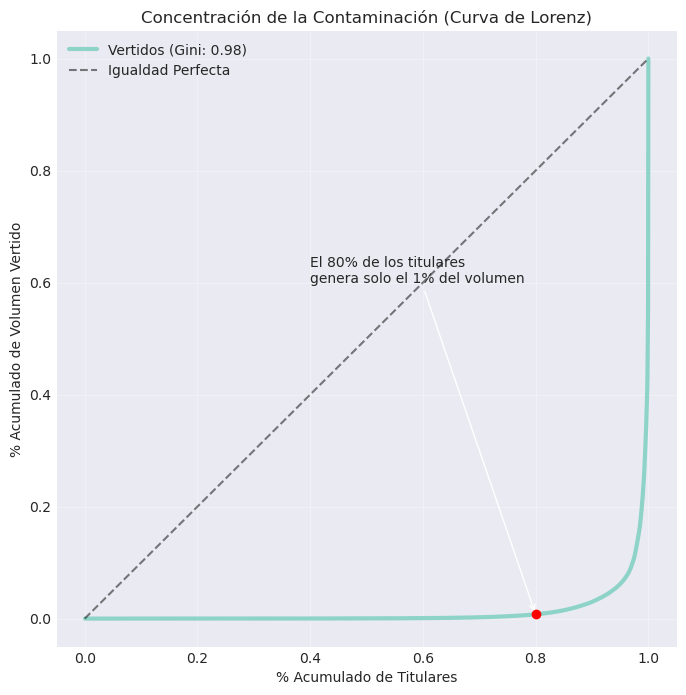

Coeficiente de Gini: 0.975
CONCLUSIÓN: Contaminación ULTRA ALTAMENTE CONCENTRADA. Pocos actores causan casi todo el daño.


In [352]:
def plot_lorenz_curve(df, col_volumen):
    # Filtramos ceros y ordenamos
    vols = df[df[col_volumen] > 0][col_volumen].sort_values().values

    # Acumulados
    cum_vols = np.cumsum(vols)
    cum_vols_norm = cum_vols / cum_vols[-1]

    # Eje X (Población acumulada)
    n = len(vols)
    x = np.arange(1, n + 1) / n

    # Gini Index (Cálculo aproximado)
    # Área bajo la curva perfecta (0.5) - Área bajo nuestra curva
    area_bajo_curva = np.trapz(cum_vols_norm, x)
    gini = 1 - 2 * area_bajo_curva

    # Plot
    plt.figure(figsize=(8, 8))
    plt.plot(x, cum_vols_norm, label=f'Vertidos (Gini: {gini:.2f})', linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--', label='Igualdad Perfecta', alpha=0.5)

    # Anotación del 80/20 (Pareto)
    idx_80 = np.searchsorted(x, 0.8)
    vol_80 = cum_vols_norm[idx_80]
    plt.scatter([0.8], [vol_80], color='red', zorder=5)
    plt.annotate(f'El 80% de los titulares\ngenera solo el {vol_80 * 100:.0f}% del volumen',
                 (0.8, vol_80), xytext=(0.4, 0.6), arrowprops=dict(arrowstyle="->"))

    plt.title("Concentración de la Contaminación (Curva de Lorenz)")
    plt.xlabel("% Acumulado de Titulares")
    plt.ylabel("% Acumulado de Volumen Vertido")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return gini


gini_score = plot_lorenz_curve(df, 'VOLUMEN_m3_ano')
print(f"Coeficiente de Gini: {gini_score:.3f}")
if gini_score > 0.95:
    print("CONCLUSIÓN: Contaminación ULTRA ALTAMENTE CONCENTRADA. Pocos actores causan casi todo el daño.")
elif gini_score > 0.8:
    print("CONCLUSIÓN: Contaminación ALTAMENTE CONCENTRADA. Pocos actores causan casi todo el daño.")

Es posible que esté demasiado sesgado, vamos a comparar industrias con ayuntamientos para que las personas físicas no distorsionen las comparativas.

/tmp/ipykernel_5532/2608433246.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_bajo_curva = np.trapz(cum_vols_norm, x)


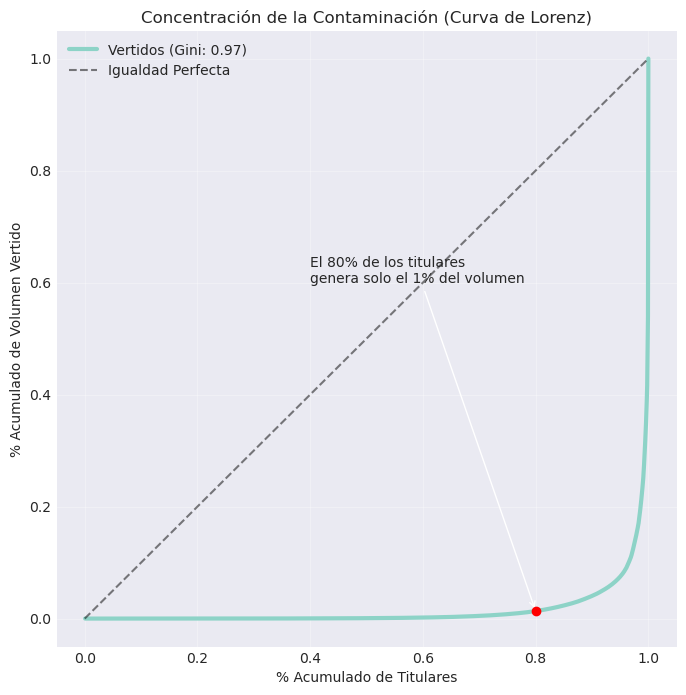

Coeficiente de Gini: 0.969
CONCLUSIÓN: Contaminación ULTRA ALTAMENTE CONCENTRADA. Pocos actores causan casi todo el daño.


In [354]:
tmp = df[df['tipo_titular'] != 'F']
gini_score = plot_lorenz_curve(tmp, 'VOLUMEN_m3_ano')
print(f"Coeficiente de Gini: {gini_score:.3f}")
if gini_score > 0.95:
    print("CONCLUSIÓN: Contaminación ULTRA ALTAMENTE CONCENTRADA. Pocos actores causan casi todo el daño.")
elif gini_score > 0.8:
    print("CONCLUSIÓN: Contaminación ALTAMENTE CONCENTRADA. Pocos actores causan casi todo el daño.")

La gráfica es un palo de hockey! De aquí podemos sacar una política real, la estrategia de vigilancia debe ser la siguiente:

* Regla del 1%: Probablemente el 1% de los titulares genera el 95% del vertido.
* Eficiencia: No tiene sentido gastar recursos vigilando a los 1.000 pequeños (particulares/chalets). Si controlas a los 50 gigantes, controlas la cuenca entera.

Vamos a visualizarlos. Preparamos el terreno (Solo vertidos con volumen > 0 para no falsear el ranking)

In [355]:
df_jerarquia = df[df['VOLUMEN_m3_ano'] > 0].copy()

Calculamos el Percentil (0 a 1) de cada vertido según su volumen

In [356]:
df_jerarquia['percentil_volumen'] = df_jerarquia['VOLUMEN_m3_ano'].rank(pct=True)

Aplicamos la Clasificación Estratégica (TIERs)

In [357]:
def clasificar_tier(p):
    if p >= 0.95:
        return 'TIER_1_CRITICO'  # El Top 5% (Los Oligarcas)
    elif p >= 0.80:
        return 'TIER_2_RELEVANTE'  # El siguiente 15% (Clase media industrial)
    else:
        return 'TIER_3_MENOR'  # El 80% restante (La cola larga)


df_jerarquia['TIER'] = df_jerarquia['percentil_volumen'].apply(clasificar_tier)

Creamos un dataframe separado para persistir luego

In [360]:
df_oligarcas = df_jerarquia[df_jerarquia['TIER'] == 'TIER_1_CRITICO'].sort_values('VOLUMEN_m3_ano', ascending=False)

# --- REPORTE DE INTELIGENCIA ---
total_volumen_cuenca = df_jerarquia['VOLUMEN_m3_ano'].sum()
volumen_oligarcas = df_oligarcas['VOLUMEN_m3_ano'].sum()
cuota_poder = (volumen_oligarcas / total_volumen_cuenca) * 100

print(f"   INFORME DE JERARQUÍA DE VERTIDOS")
print(f"   Total de expedientes analizados: {len(df_jerarquia)}")
print(f"   Miembros del 'Club TIER 1': {len(df_oligarcas)} titulares")
print(f"   ----------------------------------------------------")
print(f"   ESTE PEQUEÑO GRUPO GENERA EL {cuota_poder:.1f}% DE TODO EL VOLUMEN DE LA CUENCA.")
print(f"   ----------------------------------------------------")

print("\n  TOP 10 'OLIGARCAS' (Mayor volumen de vertido):")
cols_ver = ['TITULAR', 'MUNICIPIO', 'VOLUMEN_m3_ano', 'MEDIO_RECEPTOR', 'NATURALEZA_VERTIDO', 'tipo_titular']
display(df_oligarcas[cols_ver].head(20))

print("\n  Distribución por Naturaleza del TIER 1:")
print(df_oligarcas['NATURALEZA_VERTIDO'].value_counts())

   INFORME DE JERARQUÍA DE VERTIDOS
   Total de expedientes analizados: 1835
   Miembros del 'Club TIER 1': 93 titulares
   ----------------------------------------------------
   ESTE PEQUEÑO GRUPO GENERA EL 93.9% DE TODO EL VOLUMEN DE LA CUENCA.
   ----------------------------------------------------

  TOP 10 'OLIGARCAS' (Mayor volumen de vertido):


,TITULAR,MUNICIPIO,VOLUMEN_m3_ano,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,tipo_titular
246,"CENTRAL NUCLEAR DE ALMARAZ, C.B.",ALMARAZ,757066065.0,ARROYO ARROCAMPO,INDUSTRIAL,J
1042,AYUNTAMIENTO DE MADRID,GETAFE,107251461.0,RÍO MANZANARES,URBANO O ASIMILABLE,A
740,"PISZOLLA, S.L.",ILLANA,94608000.0,RÍO TAJO,INDUSTRIAL,J
1072,AYUNTAMIENTO DE MADRID,MADRID,42900815.0,RÍO MANZANARES,URBANO O ASIMILABLE,A
1111,AYUNTAMIENTO DE MADRID,MADRID,35611798.0,RÍO MANZANARES,URBANO O ASIMILABLE,A
1080,AYUNTAMIENTO DE MADRID,MADRID,32480478.0,RÍO MANZANARES,URBANO O ASIMILABLE,A
1083,AYUNTAMIENTO DE MADRID,MADRID,28904347.0,RÍO MANZANARES,URBANO O ASIMILABLE,A
1082,AYUNTAMIENTO DE MADRID,MADRID,23840616.0,ARROYO REJAS,URBANO O ASIMILABLE,A
1041,CANAL DE ISABEL II,GETAFE,23811361.0,ARROYO CULEBRO,URBANO O ASIMILABLE,A
827,"CENTRAL NUCLEAR DE TRILLO I, C.B.",TRILLO,23300000.0,RÍO TAJO,INDUSTRIAL,J



  Distribución por Naturaleza del TIER 1:
NATURALEZA_VERTIDO
URBANO O ASIMILABLE    80
INDUSTRIAL             13
Name: count, dtype: int64


## Análisis espacial

Ejecutamos DBSCAN (Density-Based Spatial Clustering) para identificar puntos calientes o zonas de sacrificio. Agrupa vertidos geográficamente cercanos (radio de 2km) para detectar acumulación de carga contaminante que individualmente pasaría desapercibida pero que colectivamente satura el medio receptor.

In [222]:
coords = df[['UTM_X', 'UTM_Y']]
db = DBSCAN(eps=2000, min_samples=5).fit(coords)
df['spatial_cluster'] = db.labels_

# Análisis de clusters (excluyendo ruido -1)
cluster_analysis = df[df['spatial_cluster'] != -1].groupby('spatial_cluster').agg({
    'VOLUMEN_m3_ano': 'sum',
    'TITULAR': 'count',
    'MUNICIPIO': lambda x: x.mode()[0]
}).sort_values('VOLUMEN_m3_ano', ascending=False)

print("Zonas de mayor presión hídrica acumulada:")
display(cluster_analysis.head(5))

Zonas de mayor presión hídrica acumulada:


,VOLUMEN_m3_ano,TITULAR,MUNICIPIO
spatial_cluster,,,
10,758190297.0,7,ALMARAZ
22,10145714.0,5,ALCOBENDAS
25,8025349.0,21,SAN SEBASTIAN DE LOS REYES
48,3455080.0,5,VILLASECA DE LA SAGRA
26,2157500.0,9,FUENTE EL SAZ DE JARAMA


# Autorizados a verter X red de sensores SAICA

El objetivo de esta sección es lograr generar un grafo dirigido para relacionar los autorizados del censo con los sensores que podrían detectar los vertidos

In [223]:
df.columns

Index(['NOMBRE_VERTIDO', 'TITULAR', 'MUNICIPIO', 'PROVINCIA', 'UTM_X', 'UTM_Y',
       'MEDIO_RECEPTOR', 'NATURALEZA_VERTIDO', 'CARACT_VERTIDO',
       'VOLUMEN_m3_ano', 'NATURALEZA_RECEPTOR', 'REF_EXPEDIENTE',
       'tipo_titular', 'log_vol', 'LOW_FIDELITY', 'anomaly_score', 'lof_score',
       'lof_negative_factor', 'spatial_cluster'],
      dtype='object')

In [224]:
df.head()

,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,tipo_titular,log_vol,LOW_FIDELITY,anomaly_score,lof_score,lof_negative_factor,spatial_cluster
0,DROMEN GESTORES Y CONSULTORES (VIV. UNIFAMILIAR),"DROMEN GESTORES Y CONSULTORES, S.L.",ADRADA (LA),AVILA,358144.0,4460601.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,231.0,CATEGORÍA I,AV-0006/2020,J,5.446737,False,1,1,-1.210545,0
1,PIZZERIA-RESTAURANTE PUENTE MOCHA,PERSONA FÍSICA,ADRADA (LA),AVILA,358290.0,4459633.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,1188.0,CATEGORÍA I,AV-0049/1999,F,7.080868,False,1,1,-1.210084,0
2,CENTRO HÍPICO LA ESPUELA,"CORPORACIÓN RILUMI, S.L.",ADRADA (LA),AVILA,358288.0,4459174.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,3650.0,CATEGORÍA I,AV-0041/2015,J,8.202756,True,1,1,-1.203118,0
3,EDAR LA ADRADA,AYUNTAMIENTO DE LA ADRADA,ADRADA (LA),AVILA,359461.0,4460939.0,ARROYO FRANQUILLO,URBANO O ASIMILABLE,2.000-10.000 h-e,1193058.0,CATEGORÍA I,AV-0053/2014,A,13.992031,False,1,1,-1.211816,0
4,PERSONA FÍSICA (VIVIENDAS),PERSONA FÍSICA,ADRADA (LA),AVILA,357353.0,4461118.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,102.0,CATEGORÍA I,AV-0041/2017,F,4.634729,False,1,1,-1.176477,0


Importamos las estaciones con sus coordenadas

In [225]:
stations = pd.read_json("/tmp/pycharm_project_992/data/datasets/raw/saica_stations_maestro_coords.json")

stations = stations.rename(columns={'codigo': 'id_estacion'})

stations['utm_x'] = pd.to_numeric(stations['utm_x'], errors='coerce')
stations['utm_y'] = pd.to_numeric(stations['utm_y'], errors='coerce')

stations = stations.dropna(subset=['utm_x', 'utm_y'])

stations.head()

,id_estacion,nombre,subcuenca,url_detalles,utm_x,utm_y,huso
0,C322,SAICA CARCABOSO,ALAGÓN,https://saihtajo.chtajo.es/index.php?w=get-est...,226397,4437976.0,30
1,C323,SAICA BEJAR,ALAGÓN,https://saihtajo.chtajo.es/index.php?w=get-est...,262857,4474673.0,30
2,C313,SAICA CAZALEGAS,ALBERCHE,https://saihtajo.chtajo.es/index.php?w=get-est...,354250,4430700.0,30
3,C326,SAICA ESCALONA,ALBERCHE,https://saihtajo.chtajo.es/index.php?w=get-est...,380680,4447011.0,30
4,C342,SAICA PICADAS,ALBERCHE,https://saihtajo.chtajo.es/index.php?w=get-est...,393858,4465945.0,30


Realizamos un análisis inicial a ver qué tan cerca están los autorizados de los sensores. Estos más adelante los vamos a clasificar como alta_sensibilidad

In [226]:
coords_v = df[['UTM_X', 'UTM_Y']].values
coords_s = stations[['utm_x', 'utm_y']].values

distancias = cdist(coords_v, coords_s, metric='euclidean')

umbral_metros = 5000
indices_v, indices_s = np.where(distancias < umbral_metros)

relaciones = pd.DataFrame({
    'source_id': df.iloc[indices_v]['REF_EXPEDIENTE'].values,
    'target_id': stations.iloc[indices_s]['id_estacion'].values,
    'distancia': distancias[indices_v, indices_s].round(2),
    'tipo_relacion': 'CERCANO_A'
})

print(f"Detectadas {len(relaciones)} conexiones de riesgo (distancia < 5km)")
relaciones.head()

Detectadas 212 conexiones de riesgo (distancia < 5km)


,source_id,target_id,distancia,tipo_relacion
0,AV-0166/2005,C317,4289.00,CERCANO_A
1,AV-0167/2005,C317,4289.00,CERCANO_A
2,AV-0189/2007,C317,4219.25,CERCANO_A
3,AV-0190/2007,C317,4766.89,CERCANO_A
4,AV-0061/2019,C322,607.99,CERCANO_A


Vamos a analizar la densidad de la red de sensores

In [227]:
coords_s = stations[['utm_x', 'utm_y']].values
dist_matrix_sensors = cdist(coords_s, coords_s, metric='euclidean')

# Rellenar diagonal con infinito para no encontrar distancia 0 a sí mismo
np.fill_diagonal(dist_matrix_sensors, np.inf)

# Distancia al vecino más cercano para cada sensor
min_dist_sensors = dist_matrix_sensors.min(axis=1)

print("--- ANÁLISIS DE DENSIDAD DE SENSORES (Resolución de la red) ---")
print(f"Distancia MÍNIMA entre dos sensores: {min_dist_sensors.min() / 1000:.2f} km")
print(f"Distancia MEDIA al sensor vecino: {min_dist_sensors.mean() / 1000:.2f} km")
print(f"Distancia MAXIMA (hueco más grande): {min_dist_sensors.max() / 1000:.2f} km")

--- ANÁLISIS DE DENSIDAD DE SENSORES (Resolución de la red) ---
Distancia MÍNIMA entre dos sensores: 0.60 km
Distancia MEDIA al sensor vecino: 20.48 km
Distancia MAXIMA (hueco más grande): 93.81 km


Análisis 2: Cobertura de Vertidos (Source-to-nearest-Sensor)

In [228]:
coords_v = df[['UTM_X', 'UTM_Y']].values
dist_matrix_vs = cdist(coords_v, coords_s, metric='euclidean')

# Distancia al sensor más cercano para cada vertido (k=1)
min_dist_vertidos = dist_matrix_vs.min(axis=1)

print("\n--- ANÁLISIS DE COBERTURA (Situación real de los vertidos) ---")
print(f"Vertido más cercano a un sensor: {min_dist_vertidos.min():.2f} metros")
print(f"Vertido más lejano a un sensor (Huérfano extremo): {min_dist_vertidos.max() / 1000:.2f} km")
print(f"Mediana de distancia (El 50% está a menos de...): {np.median(min_dist_vertidos) / 1000:.2f} km")
print(f"Percentil 75 (La mayoría está a menos de...): {np.percentile(min_dist_vertidos, 75) / 1000:.2f} km")

# Contar cuántos entran en diferentes radios
r5 = np.sum(min_dist_vertidos < 5000)
r10 = np.sum(min_dist_vertidos < 10000)
r20 = np.sum(min_dist_vertidos < 20000)
total = len(df)

print(f"\n--- CLASIFICACIÓN POTENCIAL ---")
print(f"Radio < 5 km: {r5} vertidos ({r5 / total:.1%})")
print(f"Radio < 10 km: {r10} vertidos ({r10 / total:.1%})")
print(f"Radio < 20 km: {r20} vertidos ({r20 / total:.1%})")


--- ANÁLISIS DE COBERTURA (Situación real de los vertidos) ---
Vertido más cercano a un sensor: 3.00 metros
Vertido más lejano a un sensor (Huérfano extremo): 92.09 km
Mediana de distancia (El 50% está a menos de...): 17.97 km
Percentil 75 (La mayoría está a menos de...): 30.91 km

--- CLASIFICACIÓN POTENCIAL ---
Radio < 5 km: 197 vertidos (10.7%)
Radio < 10 km: 454 vertidos (24.7%)
Radio < 20 km: 1025 vertidos (55.9%)


Vamos a ver si podemos clasificar por cercanía y sensor ya que ahora mismo la dimensionalidad del dato nos limita un poco en el análisis.  más adelante para hacer el grafo vamos a hacer lo siguiente. Calculamos el punto más cerca del río de cada autorizado a verter, y a partir de ahí le asignamos un sensor aguas abajo

Pedimos relaciones o vías llamadas "Río Tajo" que sean cursos de agua

In [229]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
(
  way["waterway"="river"]["name"="Río Tajo"](39.0,-6.0,41.0,-1.5);
);
out geom;
"""

Hay que poner una Bounding Box (39,-6,41,-1.5) aproximada de la cuenca alta/media, para no traernos el Tajo en Portugal y reducir ruido

Descargando geometría del Tajo desde OSM...
Tajo descargado y reproyectado a UTM 30N.
Longitud total del tramo capturado: 716.51 km


<Axes: >

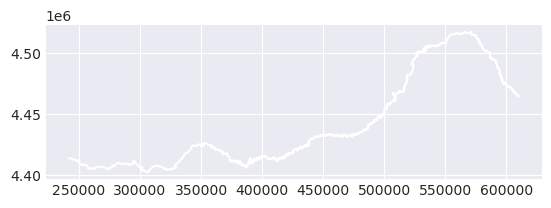

In [231]:
print("Descargando geometría del Tajo desde OSM...")
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

# Convertir respuesta JSON a Geometría
coords_list = []
for element in data['elements']:
    if 'geometry' in element:
        # Extraemos pares (lon, lat)
        points = [(pt['lon'], pt['lat']) for pt in element['geometry']]
        coords_list.append(LineString(points))

# Unimos todos los tramos sueltos en una sola línea continua
if coords_list:
    rio_tajo_bruto = linemerge(MultiLineString(coords_list))

    # Crear GeoDataFrame
    gdf_rio = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[rio_tajo_bruto])

    # REPROYECCIÓN CRÍTICA: A UTM 30N (Para coincidir con el dataset)
    gdf_rio_utm = gdf_rio.to_crs(epsg=32630)  # UTM Zone 30N

    rio_geom = gdf_rio_utm.geometry[0]

    print("Tajo descargado y reproyectado a UTM 30N.")
    print(f"Longitud total del tramo capturado: {rio_geom.length / 1000:.2f} km")
else:
    print("No se encontraron datos. Revisa la query.")

# Visualización rápida para confirmar
gdf_rio_utm.plot()

Exportar a csv para uso futuro por compañeros

In [ ]:
# gdf_rio_utm.to_csv("/tmp/pycharm_project_992/data/datasets/raw/linestring_tajo.csv")

Función de proyección hidráulica. Comenzamos definiendo la función matemática que proyectará nuestros puntos (vertidos y sensores) sobre la línea del río para obtener su posición kilométrica exacta.

In [232]:
def get_hydro_metrics(row, geom, x_col, y_col):
    """
    Proyecta un punto (UTM) sobre la línea del río.
    Retorna:
      - km_rio: Distancia desde el nacimiento hasta el punto proyectado.
      - dist_al_rio: Distancia perpendicular desde el vertido hasta la orilla.
    """
    pt = Point(row[x_col], row[y_col])
    return pd.Series([geom.project(pt), pt.distance(geom)], index=['km_rio', 'dist_al_rio'])

Aplicamos esta función a los dos DataFrames. Esto nos dará dos nuevas columnas críticas: km_rio (punto exacto del cauce) y dist_al_rio (distancia lateral a la orilla).

In [233]:
df[['km_rio', 'dist_al_rio']] = df.apply(
    get_hydro_metrics,
    axis=1,
    args=(rio_geom, 'UTM_X', 'UTM_Y')
)

stations[['km_rio', 'dist_al_rio']] = stations.apply(
    get_hydro_metrics,
    axis=1,
    args=(rio_geom, 'utm_x', 'utm_y')
)

Ahora ejecutamos la lógica de asignación. Filtramos solo los elementos que estén cerca del cauce principal (margen de 3 km) y para cada vertido buscamos el primer sensor que se encuentre aguas abajo (donde el kilometraje del sensor sea mayor que el del vertido).

In [234]:
UMBRAL_RIBERA = 3000
df_rio = df[df['dist_al_rio'] < UMBRAL_RIBERA].copy()
stations_rio = stations[stations['dist_al_rio'] < UMBRAL_RIBERA].copy()

stations_rio = stations_rio.sort_values('km_rio')

rels_hidro = []

for idx, vertido in df_rio.iterrows():
    sensores_downstream = stations_rio[stations_rio['km_rio'] > vertido['km_rio']]

    if not sensores_downstream.empty:
        sensor_dest = sensores_downstream.iloc[0]

        distancia_agua = sensor_dest['km_rio'] - vertido['km_rio']

        rels_hidro.append({
            'source_id': vertido['REF_EXPEDIENTE'],
            'target_id': sensor_dest['id_estacion'],
            'distancia': round(distancia_agua, 2),
            'tipo_relacion': 'AGUAS_ABAJO'
        })

df_relaciones_rio = pd.DataFrame(rels_hidro)
df_relaciones_rio.head()

,source_id,target_id,distancia,tipo_relacion
0,AV-0189/2007,C317,3859.03,AGUAS_ABAJO
1,AV-0200/2008,C343,28350.66,AGUAS_ABAJO
2,AV-0174/2005,C317,3859.03,AGUAS_ABAJO
3,AV-0166/2003,C316,158408.97,AGUAS_ABAJO
4,AV-0145/2004,C325,41.46,AGUAS_ABAJO


Para completar la inteligencia del grafo, nos falta la Capa de Atribución. Ya sabemos dónde está el peligro (Espacial) y a dónde va (Hidráulica), pero no sabemos quién es el responsable ni quién tiene la jurisdicción.

In [235]:
# Normalizamos el nombre del titular para evitar duplicados por espacios o mayúsculas
df['TITULAR_NORM'] = df['TITULAR'].str.strip().str.upper()

# Creamos la tabla de relaciones
rel_titular = df[['REF_EXPEDIENTE', 'TITULAR_NORM']].copy()
rel_titular.columns = ['source_id', 'target_id']
rel_titular['tipo_relacion'] = 'TIENE_TITULAR'

Relación de jurisdicción

In [236]:
df['MUNICIPIO_NORM'] = df['MUNICIPIO'].str.strip().str.upper()

rel_municipio = df[['REF_EXPEDIENTE', 'MUNICIPIO_NORM']].copy()
rel_municipio.columns = ['source_id', 'target_id']
rel_municipio['tipo_relacion'] = 'EN_MUNICIPIO'



Consolidación final para el grafo

In [237]:
dfs_aristas = [
    relaciones,  # Proximidad (calculada previamente)
    df_relaciones_rio,  # Hidráulica (calculada previamente)
    rel_titular,  # Administrativa (Titular)
    rel_municipio  # Administrativa (Municipio)
]

# Concatenamos y limpiamos duplicados si los hubiera
all_edges = pd.concat(dfs_aristas, ignore_index=True)

print(f"Total del censo: {len(df)}")
print(f"Total de sensores: {len(stations)}")
print(f"Grafo total construido: {len(all_edges)} relaciones.")
print(all_edges['tipo_relacion'].value_counts())

# Vista previa
all_edges.head()

Total del censo: 1835
Total de sensores: 30
Grafo total construido: 4028 relaciones.
tipo_relacion
EN_MUNICIPIO     1835
TIENE_TITULAR    1835
CERCANO_A         212
AGUAS_ABAJO       146
Name: count, dtype: int64


,source_id,target_id,distancia,tipo_relacion
0,AV-0166/2005,C317,4289.00,CERCANO_A
1,AV-0167/2005,C317,4289.00,CERCANO_A
2,AV-0189/2007,C317,4219.25,CERCANO_A
3,AV-0190/2007,C317,4766.89,CERCANO_A
4,AV-0061/2019,C322,607.99,CERCANO_A


De 1835 nodos vemos que no todos vierten al cuerpo principal. Vamos a agregar más información aquí sobre afluyente para poder trabajar mejor.

In [238]:
df['MEDIO_RECEPTOR'].unique()

array(['TERRENO', 'ARROYO FRANQUILLO', 'RÍO EL ARENAL',
       'ARROYO BARRITOTE', 'ARROYO EGIDO', 'RÍO ALBERCHE',
       'ARROYO DE LA PARRA', 'ARROYO DE LOS CHARQUILLOS',
       'GARGANTA DE IRUELAS', 'ARROYO NOGALERA', 'ARROYO DE VALDIBUJO',
       'REGUERO DE LAS POZAS', 'ARROYO DE VALDEMARQUINA',
       'ARROYO DE LOS GALAYOS', 'GARGANTA DE LAS TORRES', 'ARROYO PELAYO',
       'RÍO CANTOS', 'ARROYO DE LA PEGUERA', 'ARROYO MERDERO',
       'ARROYO NAVAHERMOSA', 'RÍO RAMACASTAÑAS', 'ARROYO LAS HUERTAS',
       'ARROYO LOS MORALES', 'ARROYO PRADOMOLINO', 'GARGANTA CABRERA',
       'ARROYO CONEJERO', 'ARROYO DEL REGAJO', 'ARROYO DE LAS CASAS',
       'ARROYO DE VALLE ENMEDIO', 'RÍO ACEÑA', 'GARGANTA NUÑO COJO',
       'BARRANCO VALLE', 'RÍO TIÉTAR', 'RÍO PIQUILLO',
       'ARROYO DE FUENTE HERRADA', 'RÍO AMBROZ',
       'ARROYO DE LA FUENTE DE LA ESCOBA', 'ARROYO BARQUERA',
       'ARROYO BARRIGADILLA', 'ARROYO PALOMERO', 'ARROYO LA PILETA',
       'RÍO TAJO', 'ARROYO ROAGREA', 'ARROY

Primero, contamos la frecuencia de cada río en el Censo para priorizar la descarga. No gastaremos recursos en un arroyo con un solo vertido, nos centraremos en los cauces que estructuran la cuenca.

In [239]:
top_rios = df['MEDIO_RECEPTOR'].value_counts().reset_index()
top_rios.columns = ['nombre_rio', 'num_vertidos']

# Filtramos solo los que contienen la palabra RIO para evitar arroyos menores o TERRENO
rios_objetivo = top_rios[
    (top_rios['nombre_rio'].str.contains('RÍO', na=False)) &
    (top_rios['num_vertidos'] >= 10)
    ].copy()

print(f"Identificados {len(rios_objetivo)} afluentes principales para descarga.")
print(rios_objetivo.head(10))


# Preparamos una lista limpia de nombres para la API (Title Case para OSM: "Río Jarama")
# Como OSM es sensible a mayúsculas/tildes. Convertimos "RÍO JARAMA" -> "Río Jarama"
def limpiar_nombre(nombre):
    return nombre.title()


lista_rios_a_descargar = rios_objetivo['nombre_rio'].apply(limpiar_nombre).tolist()
# Aseguramos que el Tajo esté incluido si no saliera el primero
if "Río Tajo" not in lista_rios_a_descargar:
    lista_rios_a_descargar.insert(0, "Río Tajo")

print(f"\nLista de descarga preparada: {lista_rios_a_descargar}")

Identificados 6 afluentes principales para descarga.
       nombre_rio  num_vertidos
1        RÍO TAJO            55
3      RÍO JARAMA            27
4    RÍO ALBERCHE            21
5     RÍO HENARES            20
6      RÍO TAJUÑA            15
7  RÍO GUADARRAMA            13

Lista de descarga preparada: ['Río Tajo', 'Río Jarama', 'Río Alberche', 'Río Henares', 'Río Tajuña', 'Río Guadarrama']


procedemos a descargarnos las geometrías. Verificaremos si ya tenemos el csv descargado par ano volver a descargar y haremos varios intentos en caso de no tenerlo en local

In [240]:
output_dir = "/tmp/pycharm_project_992/data/datasets/raw/"
os.makedirs(output_dir, exist_ok=True)
geo_rios = {}

print("Iniciando procesamiento de geometrías...")

for nombre_rio in lista_rios_a_descargar:
    safe_name = nombre_rio.lower().replace(" ", "_")
    filename = f"linestring_{safe_name}.csv"
    filepath = os.path.join(output_dir, filename)

    print(f"Procesando: {nombre_rio}...", end=" ")

    if os.path.exists(filepath):
        try:
            df_temp = pd.read_csv(filepath)
            geometry_wkt = df_temp.iloc[0]['geometry']
            geo_rios[nombre_rio.upper()] = wkt.loads(geometry_wkt)
            print("Cargado desde disco.")
        except Exception as e:
            print(f"Error leyendo archivo existente: {e}")
        continue

    max_retries = 5
    descarga_exitosa = False

    for intento in range(max_retries):
        query = f"""
        [out:json][timeout:180][maxsize:1073741824];
        (
          way["waterway"="river"]["name"="{nombre_rio}"](39.0,-7.0,41.5,-1.0);
        );
        out geom;
        """

        try:
            response = requests.get(overpass_url, params={'data': query}, timeout=200)

            if response.status_code == 200:
                data = response.json()
                coords_list = []

                if 'elements' in data:
                    for element in data['elements']:
                        if 'geometry' in element:
                            points = [(pt['lon'], pt['lat']) for pt in element['geometry']]
                            coords_list.append(LineString(points))

                if coords_list:
                    linea_bruta = linemerge(MultiLineString(coords_list))
                    gdf_temp = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[linea_bruta])
                    gdf_temp = gdf_temp.to_crs(epsg=32630)

                    gdf_temp.to_csv(filepath, index=False)

                    geo_rios[nombre_rio.upper()] = gdf_temp.geometry[0]

                    dist_km = gdf_temp.geometry[0].length / 1000
                    print(f"Descargado OK ({dist_km:.1f} km)")
                    descarga_exitosa = True
                    break
                else:
                    print("Vacío (sin geometría)")
                    break

            elif response.status_code == 429:
                wait_time = 10 + (intento * 5)
                print(f"(429 - Esperando {wait_time}s)...", end=" ")
                time.sleep(wait_time)
            else:
                print(f"(HTTP {response.status_code})...", end=" ")

        except Exception as e:
            print(f"(Error: {e})...", end=" ")

        if intento < max_retries - 1:
            time.sleep(5 * (intento + 1))

    if not descarga_exitosa:
        print("Falló tras reintentos.")

Iniciando procesamiento de geometrías...
Procesando: Río Tajo... Cargado desde disco.
Procesando: Río Jarama... Cargado desde disco.
Procesando: Río Alberche... Cargado desde disco.
Procesando: Río Henares... Cargado desde disco.
Procesando: Río Tajuña... Cargado desde disco.
Procesando: Río Guadarrama... Cargado desde disco.


Ahora que tenemos los ríos digitalizados (de nuevo), debemos ubicar los sensores sobre ellos. Como las coordenadas de los sensores no son perfectas, buscamos matemáticamente a qué río pertenece cada sensor. Si un sensor está a menos de 3 km del trazado de uno de estos ríos principales, lo asignamos a él.

In [241]:
print("Vinculando sensores a la red hidrográfica recuperada...")

sensor_assignments = []
stations_utm = stations.dropna(subset=['utm_x', 'utm_y'])

for idx, station in stations_utm.iterrows():
    pt = Point(station['utm_x'], station['utm_y'])

    best_rio = None
    min_dist = 100000
    best_km = -1

    for nombre_rio_key, geom in geo_rios.items():  # Iteramos sobre lo que hay en geo_rios
        dist = pt.distance(geom)
        if dist < min_dist:
            min_dist = dist
            best_rio = nombre_rio_key  # El nombre ya está en mayúsculas (ej. "RÍO TAJO")
            best_km = geom.project(pt)

    # Mantenemos el buffer de 3km
    if min_dist < 3000 and best_rio is not None:
        sensor_assignments.append({
            'id_estacion': station['id_estacion'],
            'rio_asignado': best_rio,
            'km_rio': best_km
        })

df_sensors_hydro = pd.DataFrame(sensor_assignments)
print(f"   -> {len(df_sensors_hydro)} sensores posicionados.")

Vinculando sensores a la red hidrográfica recuperada...
   -> 26 sensores posicionados.


Generación de aristas Río abajo

Primero aseguramos que el dataframe de sensores tenga las coordenadas (haciendo un merge con el maestro) para poder calcular la línea recta. 

In [242]:
sensores_con_coords = df_sensors_hydro.merge(
    stations[['id_estacion', 'utm_x', 'utm_y']],
    on='id_estacion',
    how='left'
)

Aquí ya procedemos al cálculo

In [243]:
rels_hidro_multi = []

for nombre_rio_key, geom in geo_rios.items():
    # Filtramos vertidos y sensores de este río
    vertidos_rio = df[df['MEDIO_RECEPTOR'] == nombre_rio_key].copy()
    sensores_rio = sensores_con_coords[sensores_con_coords['rio_asignado'] == nombre_rio_key].sort_values('km_rio')

    if vertidos_rio.empty or sensores_rio.empty:
        continue

    # Calculamos Km fluvial para vertidos
    vertidos_rio['km_rio'] = vertidos_rio.apply(
        lambda row: geom.project(Point(row['UTM_X'], row['UTM_Y'])), axis=1
    )

    for idx, v in vertidos_rio.iterrows():
        # Buscamos sensor aguas abajo (km mayor)
        downstream = sensores_rio[sensores_rio['km_rio'] > v['km_rio']]

        if not downstream.empty:
            s_dest = downstream.iloc[0]  # El sensor inmediato

            # Cálculo de distancias
            dist_hidra = round(s_dest['km_rio'] - v['km_rio'], 2)  # Distancia por el río
            dist_eucl = round(np.sqrt((v['UTM_X'] - s_dest['utm_x']) ** 2 + (v['UTM_Y'] - s_dest['utm_y']) ** 2),
                              2)  # Línea recta

            rels_hidro_multi.append({
                'source_id': v['REF_EXPEDIENTE'],
                'target_id': s_dest['id_estacion'],
                'distancia_hidraulica': dist_hidra,
                'distancia_euclidea': dist_eucl,
                'tipo_relacion': 'AGUAS_ABAJO',
                'detalle_rio': nombre_rio_key
            })

df_rels_hidro = pd.DataFrame(rels_hidro_multi)
print(f"Generadas {len(df_rels_hidro)} relaciones hidrológicas.")
df_rels_hidro.head()

Generadas 137 relaciones hidrológicas.


,source_id,target_id,distancia_hidraulica,distancia_euclidea,tipo_relacion,detalle_rio
0,AV-0886/1987,C316,171645.45,379650.60,AGUAS_ABAJO,RÍO TAJO
1,AV-0137/2003,C316,171895.47,379468.72,AGUAS_ABAJO,RÍO TAJO
2,AV-0146/2004,C316,158408.97,435208.01,AGUAS_ABAJO,RÍO TAJO
3,AV-0138/2003,C316,158408.97,435285.61,AGUAS_ABAJO,RÍO TAJO
4,AV-0082/1999,C316,217079.32,344523.15,AGUAS_ABAJO,RÍO TAJO


El problema es que seguimos teniendo una baja cobertura, entonces como este plan no ha dado sus frutos, vamos a asignar el resto con una arísta ASIGNADO_TEORICO.

Vamos a filtrar los que ya tenemos clasificados 

In [244]:
vertidos_cubiertos = set(df_rels_hidro['source_id'].unique()) if not df_rels_hidro.empty else set()
df_huerfanos = df[~df['REF_EXPEDIENTE'].isin(vertidos_cubiertos)].copy()

Calcular distancia de TODOS los huérfanos a TODOS los sensores para tener una matriz donde fila=vertido, col=sensor

In [245]:
coords_v = df_huerfanos[['UTM_X', 'UTM_Y']].values
coords_s = stations[['utm_x', 'utm_y']].values

dist_matrix = cdist(coords_v, coords_s, metric='euclidean')

Procedemos a encontrar el sensor más cercano para cada vertido 

In [246]:
idx_nearest = dist_matrix.argmin(axis=1)  # Índice del sensor más cercano
dist_nearest = dist_matrix.min(axis=1)  # Distancia a ese sensor

Y fiunalmente construimos el dataframe

In [247]:
rels_rescate = pd.DataFrame({
    'source_id': df_huerfanos['REF_EXPEDIENTE'].values,
    'target_id': stations.iloc[idx_nearest]['id_estacion'].values,  # Mapeamos índice a ID real
    'distancia_hidraulica': None,  # No aplica (o desconocido)
    'distancia_euclidea': np.round(dist_nearest, 2),
    'tipo_relacion': 'ASIGNADO_TEORICO',
    'detalle_rio': 'NO_MAPEAR'  # Opcional: Podríamos poner el MEDIO_RECEPTOR original
})

print(f"Rescatados {len(rels_rescate)} vertidos asignados por proximidad.")

# Unir ambos conjuntos para tener el Master de Aristas Espaciales
df_aristas_espaciales = pd.concat([df_rels_hidro, rels_rescate], ignore_index=True)

print(f"\nTotal Aristas Espaciales: {len(df_aristas_espaciales)}")
print(df_aristas_espaciales['tipo_relacion'].value_counts())
df_aristas_espaciales.head()

Rescatados 1698 vertidos asignados por proximidad.

Total Aristas Espaciales: 1835
tipo_relacion
ASIGNADO_TEORICO    1698
AGUAS_ABAJO          137
Name: count, dtype: int64


/tmp/ipykernel_5532/1046967364.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aristas_espaciales = pd.concat([df_rels_hidro, rels_rescate], ignore_index=True)


,source_id,target_id,distancia_hidraulica,distancia_euclidea,tipo_relacion,detalle_rio
0,AV-0886/1987,C316,171645.45,379650.60,AGUAS_ABAJO,RÍO TAJO
1,AV-0137/2003,C316,171895.47,379468.72,AGUAS_ABAJO,RÍO TAJO
2,AV-0146/2004,C316,158408.97,435208.01,AGUAS_ABAJO,RÍO TAJO
3,AV-0138/2003,C316,158408.97,435285.61,AGUAS_ABAJO,RÍO TAJO
4,AV-0082/1999,C316,217079.32,344523.15,AGUAS_ABAJO,RÍO TAJO


Ahora vamos proceder a generar las relaciones administrativas. Procesaremos las columnas TITULAR y MUNICIPIO del censo. Es vital normalizar los textos (quitar espacios extra y pasar a mayúsculas) para que "Empresa S.L." y "EMPRESA S.L " sean el mismo nodo. (este código ya lo ejecutamos antes pero para tener el flujo completo vamos a repetirlo)

In [248]:
df['TITULAR_NORM'] = df['TITULAR'].astype(str).str.strip().str.upper()

df_titulares = df[['REF_EXPEDIENTE', 'TITULAR_NORM']].copy()
df_titulares.columns = ['source_id', 'target_id']

df_titulares['tipo_relacion'] = 'TIENE_TITULAR'
df_titulares['distancia_euclidea'] = None
df_titulares['distancia_hidraulica'] = None
df_titulares['detalle_rio'] = None

print(f"Relaciones de Titularidad preparadas: {len(df_titulares)}")
df_titulares.head()

Relaciones de Titularidad preparadas: 1835


,source_id,target_id,tipo_relacion,distancia_euclidea,distancia_hidraulica,detalle_rio
0,AV-0006/2020,"DROMEN GESTORES Y CONSULTORES, S.L.",TIENE_TITULAR,None,None,None
1,AV-0049/1999,PERSONA FÍSICA,TIENE_TITULAR,None,None,None
2,AV-0041/2015,"CORPORACIÓN RILUMI, S.L.",TIENE_TITULAR,None,None,None
3,AV-0053/2014,AYUNTAMIENTO DE LA ADRADA,TIENE_TITULAR,None,None,None
4,AV-0041/2017,PERSONA FÍSICA,TIENE_TITULAR,None,None,None


Ahora hacemos lo mismo para la Jurisdicción Municipal. Esto conectará todos los vertidos de una misma localidad, permitiendo ver si un ayuntamiento acumula problemas sistemáticos.

In [249]:
df['MUNICIPIO_NORM'] = df['MUNICIPIO'].astype(str).str.strip().str.upper()

df_municipios = df[['REF_EXPEDIENTE', 'MUNICIPIO_NORM']].copy()
df_municipios.columns = ['source_id', 'target_id']

df_municipios['tipo_relacion'] = 'EN_MUNICIPIO'
df_municipios['distancia_euclidea'] = None
df_municipios['distancia_hidraulica'] = None
df_municipios['detalle_rio'] = None

print(f"Relaciones Municipales preparadas: {len(df_municipios)}")
df_municipios.head()

Relaciones Municipales preparadas: 1835


,source_id,target_id,tipo_relacion,distancia_euclidea,distancia_hidraulica,detalle_rio
0,AV-0006/2020,ADRADA (LA),EN_MUNICIPIO,None,None,None
1,AV-0049/1999,ADRADA (LA),EN_MUNICIPIO,None,None,None
2,AV-0041/2015,ADRADA (LA),EN_MUNICIPIO,None,None,None
3,AV-0053/2014,ADRADA (LA),EN_MUNICIPIO,None,None,None
4,AV-0041/2017,ADRADA (LA),EN_MUNICIPIO,None,None,None


Finalmente, consolidamos las tres capas de inteligencia en el único DataFrame Maestro (df_aristas_final). Este archivo contiene la física (agua), la proximidad (rescate) y la administración (policía). Es la estructura completa que inyectaremos en Neo4j.

In [250]:
dfs_to_concat = [
    df_aristas_espaciales,
    df_titulares,
    df_municipios
]

df_aristas_final = pd.concat(dfs_to_concat, ignore_index=True)

# Limpieza final de nulos en IDs por seguridad
df_aristas_final = df_aristas_final.dropna(subset=['source_id', 'target_id'])

print(f"GRAFO COMPLETO GENERADO: {len(df_aristas_final)} relaciones.")
print(df_aristas_final['tipo_relacion'].value_counts())

GRAFO COMPLETO GENERADO: 5505 relaciones.
tipo_relacion
EN_MUNICIPIO        1835
TIENE_TITULAR       1835
ASIGNADO_TEORICO    1698
AGUAS_ABAJO          137
Name: count, dtype: int64


/tmp/ipykernel_5532/2526562135.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aristas_final = pd.concat(dfs_to_concat, ignore_index=True)


Guardamos para facilitar el trabajo a los compañeros

In [251]:
# df_aristas_final.to_csv(output_dir+'Aristas_grafo_v1.csv')

## Trabajo con Neo4j
Procedemos a insertar en la base de datos especial

In [252]:
# Configuración de conexión
URI = "bolt://192.168.2.7:7687"
AUTH = ("neo4j", "12345678secret")


def limpiar_base_datos(tx):
    tx.run("MATCH (n) DETACH DELETE n")
    # Borramos también constraints e índices previos para evitar conflictos al recrear
    tx.run("CALL apoc.schema.assert({},{})")


print(f"Conectando a {URI}...")

try:
    driver = GraphDatabase.driver(URI, auth=AUTH)
    driver.verify_connectivity()

    with driver.session() as session:
        session.execute_write(limpiar_base_datos)

    print("Conexión establecida y Base de Datos formateada (Limpia).")

except Exception as e:
    print(f"Error crítico de conexión: {e}")

Conectando a bolt://192.168.2.7:7687...
Conexión establecida y Base de Datos formateada (Limpia).


Ahora cargamos los actores del sistema. Usaremos UNWIND en Cypher, que es la forma más eficiente de insertar datos masivos: pasamos la lista de diccionarios desde Python y Neo4j los procesa en batch.

Primero inyectamos los Sensores.

Neo4j pintará la propiedad name del nodo. para que se muestre bien lo vamos a parsear aquí

In [253]:
def cargar_sensores(tx, data):
    query = """
    UNWIND $batch AS row
    CREATE (s:Sensor {
        id: row.id_estacion,
        name: row.nombre,
        utm_x: row.utm_x,
        utm_y: row.utm_y,
        rio: row.subcuenca
    })
    """
    tx.run(query, batch=data)


stations_data = stations.to_dict('records')

with driver.session() as session:
    session.execute_write(cargar_sensores, stations_data)

print(f"Inyectados {len(stations_data)} nodos de Sensores.")

Inyectados 30 nodos de Sensores.


A continuación, inyectamos los Vertidos (Autorizados). Incluimos sus coordenadas y propiedades de riesgo.

In [254]:
def cargar_vertidos(tx, data):
    query = """
    UNWIND $batch AS row
    CREATE (v:Vertido {
        id: row.REF_EXPEDIENTE,
        name: row.TITULAR,
        volumen: row.VOLUMEN_m3_ano,
        actividad: row.NATURALEZA_VERTIDO,
        utm_x: row.UTM_X,
        utm_y: row.UTM_Y,
        medio_receptor: row.MEDIO_RECEPTOR
    })
    """
    tx.run(query, batch=data)


# Convertimos el censo de vertidos
vertidos_data = df.to_dict('records')

with driver.session() as session:
    session.execute_write(cargar_vertidos, vertidos_data)

print(f"Inyectados {len(vertidos_data)} nodos de Vertidos.")

Inyectados 1835 nodos de Vertidos.


Por último, creamos los nodos de la Capa Administrativa (Empresas y Municipios).

Usaremos MERGE en lugar de CREATE. MERGE actúa como un CREATE IF NOT EXISTS. Esto es vital porque múltiples vertidos pertenecen a la misma empresa o municipio, y queremos un solo nodo central para cada uno.

In [255]:
def cargar_administrativos(tx, data_empresas, data_municipios):
    # 1. Cargar Empresas
    query_emp = """
    UNWIND $batch AS n
    MERGE (e:Empresa {name: n})
    """
    tx.run(query_emp, batch=data_empresas)

    # 2. Cargar Municipios
    query_mun = """
    UNWIND $batch AS n
    MERGE (m:Municipio {name: n})
    """
    tx.run(query_mun, batch=data_municipios)


In [256]:
# Extraemos listas únicas
lista_empresas = df['TITULAR_NORM'].unique().tolist()
lista_municipios = df['MUNICIPIO_NORM'].unique().tolist()

with driver.session() as session:
    session.execute_write(cargar_administrativos, lista_empresas, lista_municipios)

print(f"Estructura administrativa creada: {len(lista_empresas)} Empresas y {len(lista_municipios)} Municipios.")

Estructura administrativa creada: 986 Empresas y 591 Municipios.


Vamos a cargar el DataFrame df_aristas_final que creamos anteriormente. Dividiremos la carga por tipo de relación para ser precisos con las propiedades (la distancia hidráulica solo aplica a unas, etc.).

Esta query conecta Vertido con Sensor.

In [257]:
def cargar_relaciones_riesgo(tx, data, tipo_relacion):
    query = f"""
    UNWIND $batch AS row
    MATCH (v:Vertido {{id: row.source_id}})
    MATCH (s:Sensor {{id: row.target_id}})
    MERGE (v)-[r:{tipo_relacion}]->(s)
    SET r.distancia_euclidea = row.distancia_euclidea,
        r.distancia_hidraulica = row.distancia_hidraulica,
        r.rio = row.detalle_rio
    """
    tx.run(query, batch=data)

Esta query conecta Vertido con Empresa o Municipio

In [258]:
def cargar_relaciones_admin(tx, data, tipo_relacion, label_destino):
    query = f"""
    UNWIND $batch AS row
    MATCH (v:Vertido {{id: row.source_id}})
    MATCH (d:{label_destino} {{name: row.target_id}})
    MERGE (v)-[r:{tipo_relacion}]->(d)
    """
    tx.run(query, batch=data)

Separamos los datos del DataFrame Maestro

In [259]:
df_aguas = df_aristas_final[df_aristas_final['tipo_relacion'] == 'AGUAS_ABAJO'].to_dict('records')
df_teorico = df_aristas_final[df_aristas_final['tipo_relacion'] == 'ASIGNADO_TEORICO'].to_dict('records')
df_titular = df_aristas_final[df_aristas_final['tipo_relacion'] == 'TIENE_TITULAR'].to_dict('records')
df_municipio = df_aristas_final[df_aristas_final['tipo_relacion'] == 'EN_MUNICIPIO'].to_dict('records')

Ejecutar los comandos

In [260]:
print("Iniciando cableado de la red...")

with driver.session() as session:
    # Carga Riesgo Hidrológico
    if df_aguas:
        session.execute_write(cargar_relaciones_riesgo, df_aguas, "AGUAS_ABAJO")
        print(f" -> Conectados {len(df_aguas)} vertidos por flujo de agua real.")

    # Carga Riesgo Proximidad (Rescate)
    if df_teorico:
        session.execute_write(cargar_relaciones_riesgo, df_teorico, "ASIGNADO_TEORICO")
        print(f" -> Conectados {len(df_teorico)} vertidos por proximidad lineal.")

    # Carga Administrativa (Empresas)
    if df_titular:
        session.execute_write(cargar_relaciones_admin, df_titular, "TIENE_TITULAR", "Empresa")
        print(f" -> Asignadas {len(df_titular)} titularidades.")

    # Carga Administrativa (Municipios)
    if df_municipio:
        session.execute_write(cargar_relaciones_admin, df_municipio, "EN_MUNICIPIO", "Municipio")
        print(f" -> Asignadas {len(df_municipio)} jurisdicciones municipales.")

print("RED OPERATIVA.")

Iniciando cableado de la red...
 -> Conectados 137 vertidos por flujo de agua real.
 -> Conectados 1698 vertidos por proximidad lineal.
 -> Asignadas 1835 titularidades.
 -> Asignadas 1835 jurisdicciones municipales.
RED OPERATIVA.


Ahora que tenemos la red general vamos a añadir más dimensiones a la base de datos

Primero vamos a conectar los sensores entre sí.

Estrategia:
1. Agrupar sensores por río.
2. Ordenarlos por kilómetro fluvial.
3. Conectar cada sensor con el SIGUIENTE en la lista.

NOTA TÉCNICA: En el Tajo, el agua va al Oeste (Portugal).  Por tanto, UTM X disminuye. Deberíamos ordenar DESCENDENTE si usamos UTM X. Ajustamos la query para ordenar por UTM X DESC (Mayor X = Este/Nacimiento -> Menor X = Oeste/Desembocadura)

In [261]:
def conectar_sensores_backbone(tx):
    # LIMPIEZA: Borramos relaciones anteriores para evitar duplicados tras el renombrado
    # Esto es para que el cuaderno pueda preservar la idempotencia
    print("Limpiando conexiones antiguas...")
    tx.run("MATCH ()-[r:FLUYE_HACIA]->() DELETE r")

    query = """
    MATCH (s:Sensor)
    WHERE s.rio IS NOT NULL
      AND NOT toUpper(s.rio) CONTAINS 'DESCONOCIDO'

    WITH s, s.rio as nombre_rio
    ORDER BY s.utm_x DESC

    WITH nombre_rio, collect(s) as sensores
    WHERE size(sensores) > 1

    UNWIND range(0, size(sensores)-2) AS i
    WITH sensores[i] AS s1, sensores[i+1] AS s2, nombre_rio

    WITH s1, s2, nombre_rio,
         sqrt((s1.utm_x - s2.utm_x)^2 + (s1.utm_y - s2.utm_y)^2) as dist_metros

    MERGE (s1)-[r:FLUYE_HACIA]->(s2)
    SET r.rio = nombre_rio,
        r.distancia = round(dist_metros, 2),
        r.tipo = 'INTRA_RIO'
    """
    tx.run(query)


print("Recalculando backbone con nombres normalizados...")
with driver.session() as session:
    session.execute_write(conectar_sensores_backbone)
    print("Backbone Intra-Río actualizado correctamente.")

Recalculando backbone con nombres normalizados...
Limpiando conexiones antiguas...
Backbone Intra-Río actualizado correctamente.


In [262]:
# Definición manual de la topología para asegurar precisión
jerarquia_cuenca = [
    {'tributario': 'RÍO HENARES', 'principal': 'RÍO JARAMA'},
    {'tributario': 'RÍO TAJUÑA', 'principal': 'RÍO JARAMA'},
    {'tributario': 'RÍO JARAMA', 'principal': 'RÍO TAJO'},
    {'tributario': 'RÍO GUADARRAMA', 'principal': 'RÍO TAJO'},
    {'tributario': 'RÍO ALBERCHE', 'principal': 'RÍO TAJO'},
    {'tributario': 'RÍO TIÉTAR', 'principal': 'RÍO TAJO'},
    {'tributario': 'RÍO ALAGÓN', 'principal': 'RÍO TAJO'},
    # Añadimos el Río Gallo que es afluente del Tajo en cabecera
    {'tributario': 'RÍO GALLO', 'principal': 'RÍO TAJO'}
]

print(f"Configurada topología para {len(jerarquia_cuenca)} confluencias.")

Configurada topología para 8 confluencias.


1. Encontrar la DESEMBOCADURA del tributario, para ellos buscamos el sensor del tributario que NO tiene conexión 'INTRA_RIO' saliente
2. Buscar candidatos en el río PRINCIPAL
3. Calcular distancia para encontrar el punto de enganche óptimo
4. Seleccionar solo el más cercano (LIMIT 1 implícito con head/collect o aggregation)
5. Crear la relación de TRIBUTARIO

In [263]:
def fase_2_confluencias(tx, jerarquia):
    print("Conectando afluentes a cauces principales...")

    query = """
    UNWIND $batch as par

    MATCH (t_end:Sensor)
    WHERE toUpper(t_end.rio) = par.tributario
      AND NOT (t_end)-[:FLUYE_HACIA {tipo: 'INTRA_RIO'}]->()

    MATCH (m_sensor:Sensor)
    WHERE toUpper(m_sensor.rio) = par.principal

    WITH t_end, m_sensor, par,
         sqrt((t_end.utm_x - m_sensor.utm_x)^2 + (t_end.utm_y - m_sensor.utm_y)^2) as dist
    ORDER BY dist ASC

    WITH t_end, head(collect([m_sensor, dist])) as match_data, par
    WITH t_end, match_data[0] as target_sensor, match_data[1] as dist_final, par

    MERGE (t_end)-[r:FLUYE_HACIA]->(target_sensor)
    SET r.tipo = 'TRIBUTARIO',
        r.distancia = round(dist_final, 2),
        r.rio = 'CONFLUENCIA: ' + par.tributario + ' -> ' + par.principal
    """
    tx.run(query, batch=jerarquia)


with driver.session() as session:
    session.execute_write(fase_2_confluencias, jerarquia_cuenca)
    print("Fase 2 completada: Sistema hídrico totalmente conectado.")

Conectando afluentes a cauces principales...
Fase 2 completada: Sistema hídrico totalmente conectado.


El script anterior no consiguió hacer nada.

In [264]:
def auditar_rios(tx):
    query = """
    MATCH (s:Sensor)
    WHERE s.rio IS NOT NULL
    RETURN DISTINCT toUpper(trim(s.rio)) as rio, count(s) as num_sensores
    ORDER BY rio
    """
    result = tx.run(query)
    print(f"{'RÍO (EN BASE DE DATOS)':<30} | {'SENSORES'}")
    print("-" * 45)
    data = [record for record in result]
    for record in data:
        print(f"{record['rio']:<30} | {record['num_sensores']}")
    return [d['rio'] for d in data]


print("Auditoría de Nombres en Neo4j:")
with driver.session() as session:
    rios_existentes = session.execute_write(auditar_rios)

Auditoría de Nombres en Neo4j:
RÍO (EN BASE DE DATOS)         | SENSORES
---------------------------------------------
ALAGÓN                         | 2
ALBERCHE                       | 3
BAJO TAJO                      | 4
CABECERA                       | 4
HENARES                        | 2
MADRID                         | 8
TAJO IZQUIERDA                 | 5
TIÉTAR                         | 1
ÁRRAGO                         | 1


Los datos no tienen nombres de ríos! tienen nombres de Subcuencas (ej: BAJO TAJO, CABECERA, MADRID).

Por eso el código anterior no hacía nada: buscaba RÍO TAJO y en tu base de datos se llama CABECERA o BAJO TAJO. Buscaba RÍO JARAMA y tus sensores están etiquetados bajo la zona MADRID.

Vamos a normalizar los nombres en la base de datos antes de conectar nada. Vamos a ejecutar una operación de Renombrado (hay 30 sensores no es muy grave) para convertir esas zonas administrativas en los ríos físicos que representan.

In [265]:
def normalizar_nombres_rios(tx):
    print("Normalizando nombres de ríos en la base de datos...")

    # 1. Unificar el Gran Río Tajo
    tx.run("""
    MATCH (s:Sensor)
    WHERE s.rio IN ['CABECERA', 'BAJO TAJO', 'TAJO IZQUIERDA']
    SET s.rio_original = s.rio,
        s.rio = 'RÍO TAJO'
    """)

    # 2. Asignar Zona Madrid al Jarama (Colector principal)
    tx.run("""
    MATCH (s:Sensor)
    WHERE s.rio = 'MADRID'
    SET s.rio_original = s.rio,
        s.rio = 'RÍO JARAMA'
    """)

    # 3. Prefijar los demás (Henares, Alberche, etc.)
    # Si ya tienen "RÍO" no lo tocamos, si no, se lo ponemos.
    tx.run("""
    MATCH (s:Sensor)
    WHERE NOT s.rio STARTS WITH 'RÍO'
    SET s.rio_original = s.rio,
        s.rio = 'RÍO ' + s.rio
    """)


print("Iniciando normalización...")
with driver.session() as session:
    session.execute_write(normalizar_nombres_rios)
    print("Nombres corregidos. Ahora 'CABECERA' y 'BAJO TAJO' son 'RÍO TAJO'.")

Iniciando normalización...
Normalizando nombres de ríos en la base de datos...
Nombres corregidos. Ahora 'CABECERA' y 'BAJO TAJO' son 'RÍO TAJO'.


Como hemos cambiado los nombres (ahora el Tajo es mucho más largo porque hemos unido 3 zonas), tenemos que recalcular la columna vertebral interna.

In [266]:
with driver.session() as session:
    session.execute_write(conectar_sensores_backbone)
    print("Backbone actualizado.")

Limpiando conexiones antiguas...
Backbone actualizado.


Ahora tras revisar la base de datos tenemos la jerarquía real

In [267]:
jerarquia_real = [
    {'tributario': 'RÍO HENARES', 'principal': 'RÍO JARAMA'},
    {'tributario': 'RÍO JARAMA', 'principal': 'RÍO TAJO'},
    {'tributario': 'RÍO ALBERCHE', 'principal': 'RÍO TAJO'},
    {'tributario': 'RÍO TIÉTAR', 'principal': 'RÍO TAJO'},
    {'tributario': 'RÍO ALAGÓN', 'principal': 'RÍO TAJO'},
    {'tributario': 'RÍO ÁRRAGO', 'principal': 'RÍO ALAGÓN'}
]

Ejecutamos. La misma lógica que antes. Pero ahora voy a verificar que se ha guardado bien

In [268]:
def conectar_confluencias_final(tx, jerarquia):
    print("Uniendo afluentes...")
    for par in jerarquia:
        trib = par['tributario']
        princ = par['principal']

        query = """
        MATCH (t:Sensor) WHERE t.rio = $trib AND NOT (t)-[:FLUYE_HACIA {tipo: 'INTRA_RIO'}]->()
        WITH t
        LIMIT 1

        MATCH (p:Sensor) WHERE p.rio = $princ

        WITH t, p, sqrt((t.utm_x - p.utm_x)^2 + (t.utm_y - p.utm_y)^2) as dist
        ORDER BY dist ASC
        LIMIT 1

        MERGE (t)-[r:FLUYE_HACIA]->(p)
        SET r.tipo = 'TRIBUTARIO',
            r.distancia = round(dist, 2),
            r.rio = 'CONFLUENCIA'
        RETURN t.name, p.name, dist
        """
        result = tx.run(query, trib=trib, princ=princ).single()

        if result:
            print(f"{trib} se une a {princ} ({result['t.name']} -> {result['p.name']})")
        else:
            print(f"No se pudo unir {trib} con {princ} (¿Faltan sensores en el mapa?)")


with driver.session() as session:
    session.execute_write(conectar_confluencias_final, jerarquia_real)

Uniendo afluentes...
RÍO HENARES se une a RÍO JARAMA (SAICA ESPINILLOS -> SAICA MEJORADA)
RÍO JARAMA se une a RÍO TAJO (SAICA BARGAS -> SAICA SAFONT)
RÍO ALBERCHE se une a RÍO TAJO (SAICA CAZALEGAS -> SAICA TALAVERA)
RÍO TIÉTAR se une a RÍO TAJO (SAICA MONFRAGÜE -> SAICA TORREJON-TAJO)
RÍO ALAGÓN se une a RÍO TAJO (SAICA CARCABOSO -> SAICA TORREJON-TAJO)
RÍO ÁRRAGO se une a RÍO ALAGÓN (SAICA RIVERA DE GATA -> SAICA CARCABOSO)


Por último, activamos el plugin geoespacial

In [272]:
def convertir_a_geoespacial(tx):
    print("1. Creando objetos Point() en Sensores...")
    tx.run("""
    MATCH (s:Sensor)
    WHERE s.utm_x IS NOT NULL
    SET s.location = point({x: s.utm_x, y: s.utm_y, crs: 'cartesian'})
    """)

    print("2. Creando objetos Point() en Vertidos...")
    tx.run("""
    MATCH (v:Vertido)
    WHERE v.utm_x IS NOT NULL
    SET v.location = point({x: v.utm_x, y: v.utm_y, crs: 'cartesian'})
    """)


print("Actualizando datos geoespaciales...")
with driver.session() as session:
    session.execute_write(convertir_a_geoespacial)
    print("Datos convertidos a formato nativo.")

Actualizando datos geoespaciales...
1. Creando objetos Point() en Sensores...
2. Creando objetos Point() en Vertidos...
Datos convertidos a formato nativo.


Crear los índices para búsquedas rápidas

In [273]:
print("Creando índices geoespaciales...")

with driver.session() as session:
    # Índice para Sensores
    try:
        session.run("CREATE POINT INDEX sensor_geo_idx IF NOT EXISTS FOR (s:Sensor) ON (s.location)")
        print("-> Índice 'sensor_geo_idx' verificado.")
    except Exception as e:
        print(f"Error en índice Sensores: {e}")

    # Índice para Vertidos
    try:
        session.run("CREATE POINT INDEX vertido_geo_idx IF NOT EXISTS FOR (v:Vertido) ON (v.location)")
        print("   -> Índice 'vertido_geo_idx' verificado.")
    except Exception as e:
        print(f"Error en índice Vertidos: {e}")

print("Capacidad GIS activada.")

Creando índices geoespaciales...
-> Índice 'sensor_geo_idx' verificado.
   -> Índice 'vertido_geo_idx' verificado.
✅ Capacidad GIS activada.


Ahora probemos que funciona:

In [274]:
def prueba_radar(tx):
    # Buscamos un sensor al azar para usarlo de centro
    query = """
    MATCH (centro:Sensor)
    WITH centro LIMIT 1

    MATCH (v:Vertido)
    WHERE point.distance(v.location, centro.location) < 5000  // < 5000 metros (5km)

    RETURN centro.name as Origen,
           v.name as Vertido_Cercano,
           round(point.distance(v.location, centro.location)) as Metros_Distancia
    ORDER BY Metros_Distancia ASC
    LIMIT 5
    """
    return list(tx.run(query))


print("\nProbando RADAR (Vertidos a < 5km de un sensor aleatorio):")
with driver.session() as session:
    resultados = session.execute_read(prueba_radar)
    for r in resultados:
        print(f"- Desde {r['Origen']}: '{r['Vertido_Cercano']}' a {r['Metros_Distancia']}m")


Probando RADAR (Vertidos a < 5km de un sensor aleatorio):
- Desde SAICA CARCABOSO: 'AYUNTAMIENTO DE CARCABOSO' a 608.0m
- Desde SAICA CARCABOSO: 'PERSONA FÍSICA' a 1585.0m


Metemos la tier list que habíamos creado anteriormente en la fase de análisis

Si es TIER 1, le ponemos la etiqueta :ObjetivoPrioritario usando el truco de FOREACH para condicionales en Cypher

In [361]:
def persistir_jerarquia_vertidos(tx, datos):
    query = """
    UNWIND $batch as row
    MATCH (v:Vertido {id: row.REF_EXPEDIENTE})

    SET v.categoria_estrategica = row.TIER,
        v.percentil_volumen = round(row.percentil_volumen, 4)

    FOREACH (_ IN CASE WHEN row.TIER = 'TIER_1_CRITICO' THEN [1] ELSE [] END |
        SET v:ObjetivoPrioritario
    )

    // Limpiar la etiqueta de los que ya no lo son
    FOREACH (_ IN CASE WHEN row.TIER <> 'TIER_1_CRITICO' THEN [1] ELSE [] END |
    REMOVE v:ObjetivoPrioritario
    )
    """
    tx.run(query, batch=datos)

Preparamos los datos limpios

In [362]:
datos_exportar = df_jerarquia[['REF_EXPEDIENTE', 'TIER', 'percentil_volumen']].to_dict('records')

print(f"Persistiendo clasificación estratégica para {len(datos_exportar)} vertidos...")

with driver.session() as session:
    session.execute_write(persistir_jerarquia_vertidos, datos_exportar)
    print("Grafo actualizado. Los 'Oligarcas' ahora están marcados.")

Persistiendo clasificación estratégica para 1835 vertidos...
✅ Grafo actualizado. Los 'Oligarcas' ahora están marcados.


## Análisis forense inverso
Si un sensor da la alarma, quiénes son los sospechosos aguas arriba? Filtrando por TIER 1

Según nuestra entrega esta es la baseline contra el que se medirá el modelo futuro. Heurística de subiendo el río

Primero necesitamos una víctima. Vamos a usar un sensor que yo he elegido.

In [371]:
nombre_sensor_alarma = "SAICA PUENTE LARGO"
nombre_rio = "RÍO JARAMA"

print(f"ALARMA ACTIVADA (Simulación Manual)!")
print(f"PUNTO DE CONTROL: {nombre_sensor_alarma}")
print(f"RÍO: {nombre_rio}")
print("   -> Listo para ejecutar el rastreo aguas arriba en la siguiente celda.")

¡ALARMA ACTIVADA (Simulación Manual)!
PUNTO DE CONTROL: SAICA PUENTE LARGO
RÍO: RÍO JARAMA
   -> Listo para ejecutar el rastreo aguas arriba en la siguiente celda.


Nuestra estrategia de búsqueda es hacia arriba.

La flecha <-[:FLUYE_HACIA*]. Es una flecha que va hacia atrás en el tiempo y el espacio. Le decimos a Neo4j: Empieza en la alarma y camina río arriba saltando de sensor en sensor hasta encontrar vertidos.

In [379]:
query_sherlock = """
MATCH (s_alarma:Sensor {name: $nombre_sensor})

// A. RASTREO UPSTREAM (Capturando el camino)
MATCH path = (s_upstream:Sensor)-[:FLUYE_HACIA*0..100]->(s_alarma)

// B. BUSCAMOS VERTIDOS
MATCH (v:Vertido)-[:AGUAS_ABAJO]->(s_upstream)
WHERE v:ObjetivoPrioritario

// C. SALTAMOS AL NODO MUNICIPIO (Graph Traversal)
// Buscamos el nodo conectado para municipio
// Usamos '--' para que funcione sin importar cómo llamaste a la relación (:UBICADO_EN, :PERTENECE_A...)
OPTIONAL MATCH (v)-->(m:Municipio)

RETURN v.name as SOSPECHOSO,
       m.name as MUNICIPIO,
       v.volumen as VOLUMEN,
       v.actividad as TIPO,
       length(path) as DISTANCIA_NODOS,
       s_upstream.name as PUNTO_ENTRADA
ORDER BY DISTANCIA_NODOS ASC
LIMIT 10
"""

print("Query lista")

Query lista


Ahora lanzamos a los perros de presa. Ejecutamos la query usando el nombre del sensor que obtuvimos en el Paso 1.

In [380]:
print(f"Rastreando el río {nombre_rio} aguas arriba desde {nombre_sensor_alarma}...")

with driver.session() as session:
    # Pasamos el nombre del sensor como parámetro ($nombre_sensor)
    lista_sospechosos = list(session.run(query_sherlock, nombre_sensor=nombre_sensor_alarma))

print(f"Se han encontrado {len(lista_sospechosos)} instalaciones críticas aguas arriba.")

Rastreando el río RÍO JARAMA aguas arriba desde SAICA PUENTE LARGO...
Se han encontrado 10 instalaciones críticas aguas arriba.


Finalmente, presentamos los datos de forma limpia para que podamos tomar decisiones. Convertimos los resultados crudos de Neo4j en un DataFrame bonito.

In [381]:
if lista_sospechosos:
    # Convertimos a DataFrame
    df_forense = pd.DataFrame([dict(r) for r in lista_sospechosos])

    df_forense.fillna({'MUNICIPIO': 'Desconocido', 'VOLUMEN': 0, 'TIPO': 'No especificado'}, inplace=True)

    # Formateamos el volumen para que se lea mejor (ej: 1,000,000)
    df_forense['VOLUMEN'] = df_forense['VOLUMEN'].apply(lambda x: f"{x:,.0f} m3")

    # Reordenamos columnas para máxima legibilidad
    cols = ['DISTANCIA_NODOS', 'SOSPECHOSO', 'MUNICIPIO', 'VOLUMEN', 'TIPO', 'PUNTO_ENTRADA']

    print("\nINFORME DE SOSPECHOSOS PRIORITARIOS (ORDENADOS POR CERCANÍA)")
    print("=" * 80)
    display(df_forense[cols])

    # Conclusión automática
    principal = df_forense.iloc[0]
    print(f"\n"
          f" CONCLUSIÓN PRELIMINAR:")
    print(f"   El vertido TIER 1 más cercano a la alarma es '{principal['SOSPECHOSO']}'.")
    print(f"   Se encuentra a {principal['DISTANCIA_NODOS']} tramos de sensor de distancia.")
    print(f"   Es una instalación de tipo {principal['TIPO']} ubicada en {principal['MUNICIPIO']}.")

else:
    print("\n AGUA LIMPIA (O FALSA ALARMA):")
    print("   No hay grandes vertidos 'ObjetivoPrioritario' conectados aguas arriba en este tramo.")
    print("   La contaminación podría venir de vertidos pequeños (TIER 3) o fuentes difusas.")


INFORME DE SOSPECHOSOS PRIORITARIOS (ORDENADOS POR CERCANÍA)


,DISTANCIA_NODOS,SOSPECHOSO,MUNICIPIO,VOLUMEN,TIPO,PUNTO_ENTRADA
0,0,CANAL DE ISABEL II,CIEMPOZUELOS,"8,988,207 m3",URBANO O ASIMILABLE,SAICA PUENTE LARGO
1,1,CANAL DE ISABEL II,FUENTE EL SAZ DE JARAMA,"2,147,536 m3",URBANO O ASIMILABLE,SAICA ALGETE
2,1,CANAL DE ISABEL II,ALGETE,"1,489,122 m3",URBANO O ASIMILABLE,SAICA ALGETE
3,3,CANAL DE ISABEL II,SAN SEBASTIAN DE LOS REYES,"4,610,031 m3",URBANO O ASIMILABLE,SAICA MEJORADA
4,3,CANAL DE ISABEL II,SAN FERNANDO DE HENARES,"14,099,448 m3",URBANO O ASIMILABLE,SAICA MEJORADA
5,3,AYUNTAMIENTO DE MADRID,MADRID,"11,332,523 m3",URBANO O ASIMILABLE,SAICA MEJORADA
6,3,CANAL DE ISABEL II,SAN FERNANDO DE HENARES,"11,421,882 m3",URBANO O ASIMILABLE,SAICA MEJORADA
7,4,CANAL DE ISABEL II,ARGANDA DEL REY,"4,247,657 m3",URBANO O ASIMILABLE,SAICA RIVAS
8,4,CANAL DE ISABEL II,VELILLA DE SAN ANTONIO,"4,265,524 m3",URBANO O ASIMILABLE,SAICA RIVAS
9,4,CANAL DE ISABEL II,ALCALA DE HENARES,"21,535,000 m3",URBANO O ASIMILABLE,SAICA ESPINILLOS



💡 CONCLUSIÓN PRELIMINAR:
   El vertido TIER 1 más cercano a la alarma es 'CANAL DE ISABEL II'.
   Se encuentra a 0 tramos de sensor de distancia.
   Es una instalación de tipo URBANO O ASIMILABLE ubicada en CIEMPOZUELOS.


## Análisis de cruces entre residuos urbanos e industriales
Un vertido urbano suele traer materia orgánica (nitratos, fosfatos). Un vertido industrial trae metales pesados o químicos sintéticos. Por separado son malos, pero juntos pueden reaccionar y ser peores.

Usaremos el mismo sensor de arriba, de Madrid. Como vimos que es el dato más representativo del dataset

In [382]:
query_coctel = """
MATCH (s:Sensor)

// RASTREO DOWNSTREAM (Hacia abajo)
// Buscamos vertidos (v) que, bajando por el río, acaben pasando por este sensor (s)
OPTIONAL MATCH (v:Vertido)-[:AGUAS_ABAJO]->(entry_point)-[:FLUYE_HACIA*0..]->(s)

// AGREGACIÓN
// Creamos una lista con los tipos únicos de actividad que llegan a este sensor
WITH s,
     collect(DISTINCT toUpper(v.actividad)) as mezcla,
     count(v) as num_fuentes,
     sum(v.volumen) as carga_total

// FILTRO DE "CÓCTEL TÓXICO"
// Queremos sensores que tengan AMBOS ingredientes:
WHERE any(tipo in mezcla WHERE tipo CONTAINS 'URBANO')      // Tiene componente Urbano
  AND any(tipo in mezcla WHERE tipo CONTAINS 'INDUSTRIAL')  // Y TAMBIÉN componente Industrial

RETURN s.name as SENSOR,
       s.rio as RIO,
       mezcla as INGREDIENTES,
       num_fuentes as CANTIDAD_VERTIDOS,
       carga_total as VOLUMEN_ACUMULADO
ORDER BY carga_total DESC
LIMIT 15
"""

print("Algoritmo de detección de mezclas químicas cargado.")

Algoritmo de detección de mezclas químicas cargado.


Ahora lanzamos la búsqueda en toda la cuenca del Tajo.

In [385]:
print("Analizando la composición química del agua en toda la red...")

with driver.session() as session:
    resultados_coctel = list(session.run(query_coctel))

if resultados_coctel:
    # Crear DataFrame
    df_coctel = pd.DataFrame([dict(r) for r in resultados_coctel])

    # Formatear para que se vea profesional
    df_coctel['VOLUMEN_ACUMULADO'] = df_coctel['VOLUMEN_ACUMULADO'].apply(lambda x: f"{x:,.0f} m3")

    # Limpiar la lista de ingredientes para que no ocupe mucho (join con comas)
    df_coctel['INGREDIENTES'] = df_coctel['INGREDIENTES'].apply(lambda x: ", ".join(x))

    print(
        f"\nALERTA: Se han detectado {len(df_coctel)} puntos de {len(stations)} de mezcla crítica (Urbano + Industrial).")
    print("   Estos sensores requieren monitoreo de metales pesados y toxicidad compleja.")
    print("=" * 100)

    # Mostrar tabla
    display(df_coctel[['SENSOR', 'RIO', 'CANTIDAD_VERTIDOS', 'VOLUMEN_ACUMULADO', 'INGREDIENTES']])

    # Highlight del peor caso
    peor_caso = df_coctel.iloc[0]
    print(f"\nZONA CERO DEL CÓCTEL:")
    print(
        f"   El sensor '{peor_caso['SENSOR']}' en el {peor_caso['RIO']} recibe vertidos de {peor_caso['CANTIDAD_VERTIDOS']} fuentes distintas.")
    print(f"   Es el punto de mayor riesgo químico combinado.")

else:
    print("No se encontraron puntos de mezcla crítica Urbano-Industrial en la red actual.")

Analizando la composición química del agua en toda la red...

ALERTA: Se han detectado 15 puntos de 30 de mezcla crítica (Urbano + Industrial).
   Estos sensores requieren monitoreo de metales pesados y toxicidad compleja.


,SENSOR,RIO,CANTIDAD_VERTIDOS,VOLUMEN_ACUMULADO,INGREDIENTES
0,SAICA TORREJON-TAJO,RÍO TAJO,137,"304,569,485 m3","URBANO O ASIMILABLE, INDUSTRIAL"
1,SAICA CEDILLO,RÍO TAJO,137,"304,569,485 m3","URBANO O ASIMILABLE, INDUSTRIAL"
2,SAICA ALMARAZ,RÍO TAJO,136,"304,569,211 m3","URBANO O ASIMILABLE, INDUSTRIAL"
3,SAICA VALDECAÑAS,RÍO TAJO,135,"304,568,554 m3","URBANO O ASIMILABLE, INDUSTRIAL"
4,SAICA AZUTAN,RÍO TAJO,134,"304,568,335 m3","URBANO O ASIMILABLE, INDUSTRIAL"
5,SAICA TALAVERA,RÍO TAJO,133,"304,568,061 m3","URBANO O ASIMILABLE, INDUSTRIAL"
6,SAICA ESTIVIEL,RÍO TAJO,118,"301,453,524 m3","URBANO O ASIMILABLE, INDUSTRIAL"
7,SAICA SAFONT,RÍO TAJO,112,"301,137,704 m3","URBANO O ASIMILABLE, INDUSTRIAL"
8,SAICA TITULCIA,RÍO TAJO,45,"151,823,250 m3","URBANO O ASIMILABLE, INDUSTRIAL"
9,SAICA BARGAS,RÍO JARAMA,56,"131,279,670 m3","URBANO O ASIMILABLE, INDUSTRIAL"



ZONA CERO DEL CÓCTEL:
   El sensor 'SAICA TORREJON-TAJO' en el RÍO TAJO recibe vertidos de 137 fuentes distintas.
   Es el punto de mayor riesgo químico combinado.


## Zonas de Impunidad

Si tú quisieras verter algo ilegalmente, no lo harías justo encima de un sensor. Lo harías lo más lejos posible aguas arriba de uno. Este script calcula la Distancia de Impunidad: ¿Cuántos nodos/km recorre un vertido hasta que se encuentra con el primer control?

In [391]:
query_blind_spots = """
MATCH (v:Vertido)

// 1. Buscamos el PRIMER sensor que se encuentra aguas abajo (el más cercano)
MATCH path = shortestPath((v)-[:AGUAS_ABAJO|FLUYE_HACIA*]->(s:Sensor))

WITH v, s, length(path) as distancia_nodos

// 2. FILTRO: Consideramos Zona Ciega si hay más de 5 tramos sin vigilar
WHERE distancia_nodos > 5

// 3. RECUPERAMOS EL MUNICIPIO POR RELACIÓN (GRAPH TRAVERSAL)
OPTIONAL MATCH (v)-->(m:Municipio)

RETURN v.name as SOSPECHOSO,         // Usamos v.name según tu esquema
       m.name as UBICACION,          // Leemos el nombre del NODO Municipio
       v.actividad as TIPO,          // Usamos v.actividad
       s.name as PRIMER_CONTROL,
       distancia_nodos as TRAMOS_SIN_VIGILAR
ORDER BY distancia_nodos DESC
LIMIT 15
"""

print("Buscando agujeros negros en la red de vigilancia...")

Buscando agujeros negros en la red de vigilancia...


In [392]:
with driver.session() as session:
    blind_spots = list(session.run(query_blind_spots))

if blind_spots:
    df_blind = pd.DataFrame([dict(r) for r in blind_spots])

    print(f"\nSE HAN DETECTADO {len(blind_spots)} VERTIDOS EN ZONA DE SOMBRA:")
    print("   Estos vertidos recorren una gran distancia antes de ser monitoreados.")
    print("   Si ocurren vertidos ilegales aquí, tardaremos mucho en detectarlos.")
    print("=" * 90)
    display(df_blind)
else:
    print("La red es robusta: Todos los vertidos tienen un sensor relativamente cerca.")


SE HAN DETECTADO 15 VERTIDOS EN ZONA DE SOMBRA:
   Estos vertidos recorren una gran distancia antes de ser monitoreados.
   Si ocurren vertidos ilegales aquí, tardaremos mucho en detectarlos.


,SOSPECHOSO,UBICACION,TIPO,PRIMER_CONTROL,TRAMOS_SIN_VIGILAR
0,"AGUAS DANONE, S.A.",BAIDES,INDUSTRIAL,SAICA CEDILLO,17
1,"CERVEZAS MAHOU, S.L.",ALOVERA,INDUSTRIAL,SAICA CEDILLO,17
2,AYUNTAMIENTO DE GUADALAJARA,GUADALAJARA,URBANO O ASIMILABLE,SAICA CEDILLO,17
3,AYUNTAMIENTO DE AZUQUECA DE HENARES,AZUQUECA DE HENARES,URBANO O ASIMILABLE,SAICA CEDILLO,17
4,AYUNTAMIENTO DE ESPINOSA DE HENARES,ESPINOSA DE HENARES,URBANO O ASIMILABLE,SAICA CEDILLO,17
5,AYUNTAMIENTO DE JADRAQUE,JADRAQUE,URBANO O ASIMILABLE,SAICA CEDILLO,17
6,AYUNTAMIENTO DE ALOVERA,ALOVERA,URBANO O ASIMILABLE,SAICA CEDILLO,17
7,AYUNTAMIENTO DE ALOVERA,ALOVERA,URBANO O ASIMILABLE,SAICA CEDILLO,17
8,AGENCIA ESTATAL CONSEJO SUPERIOR INVESTIGACION...,ALCALA DE HENARES,URBANO O ASIMILABLE,SAICA CEDILLO,16
9,"CEMENTERIO JARDIN ALCALA DE HENARES, S.A.",ALCALA DE HENARES,URBANO O ASIMILABLE,SAICA CEDILLO,16


## El Sensor Mártir, carga Exclusiva
Ahora mirémoslo al revés. Hay sensores que están tranquilos vigilando un arroyo, y hay sensores que soportan el peso del mundo. Vamos a calcular el Stress

Dimle vamos a preguntar a la base de datos qué vertidos caen en el tramo inmediatamente anterior a este sensor, antes de que hubiera otro sensor vigilando

Para hacer esto en Cypher, usamos un truco de grafos muy elegante: buscamos el camino desde el Vertido hasta el Sensor, pero prohibimos que haya otros sensores en medio.

In [395]:
query_exclusive_load = """
MATCH (s:Sensor)

// 1. Buscamos caminos desde vertidos hacia este sensor
MATCH path = (v:Vertido)-[:AGUAS_ABAJO|FLUYE_HACIA*1..100]->(s)

// 2. EL FILTRO MÁGICO (RESET)
// Verificamos que en el camino NO haya ningún otro nodo intermedio que sea Sensor.
// Esto garantiza que 's' es el PRIMER sensor que se encuentra el vertido.
WHERE none(n IN nodes(path)[1..-1] WHERE n:Sensor)

// 3. Agregamos
WITH s,
     count(v) as num_vertidos_locales,
     sum(v.volumen) as volumen_local_m3

// Filtramos ruido
WHERE volumen_local_m3 > 0

RETURN s.name as SENSOR,
       s.rio as RIO,
       num_vertidos_locales as NUEVOS_VERTIDOS_TRAMO,
       volumen_local_m3 as CARGA_INCREMENTAL
ORDER BY volumen_local_m3 DESC
LIMIT 12
"""

print("Calculando la carga de estrés de cada sensor...")

Calculando la carga de estrés de cada sensor...


In [397]:
with driver.session() as session:
    exclusive_results = list(session.run(query_exclusive_load))

if exclusive_results:
    df_exclusive = pd.DataFrame([dict(r) for r in exclusive_results])

    # Formato
    df_exclusive['CARGA_INCREMENTAL'] = df_exclusive['CARGA_INCREMENTAL'].apply(lambda x: f"{x:,.0f}")

    print("\nTOP SENSORES CON MAYOR APORTE DE CONTAMINACIÓN NUEVA:")
    print("   (Estos sensores vigilan los tramos donde REALMENTE se está ensuciando el río)")
    print("=" * 90)
    display(df_exclusive)

    top_1 = df_exclusive.iloc[0]
    print(f"\nEL PUNTO NEGRO LOCAL:")
    print(f"   El tramo que termina en '{top_1['SENSOR']}' ({top_1['RIO']})")
    print(f"   recibe {top_1['CARGA_INCREMENTAL']} m3 de vertido 'fresco' que no venía de antes.")
else:
    print("No se encontraron resultados (revisa si la relación Vertido->Río está bien conectada).")


TOP SENSORES CON MAYOR APORTE DE CONTAMINACIÓN NUEVA:
   (Estos sensores vigilan los tramos donde REALMENTE se está ensuciando el río)


,SENSOR,RIO,NUEVOS_VERTIDOS_TRAMO,CARGA_INCREMENTAL
0,SAICA VILLARRUBIA,RÍO TAJO,10,"97,150,572"
1,SAICA MEJORADA,RÍO JARAMA,10,"42,505,660"
2,SAICA TITULCIA,RÍO TAJO,15,"28,363,176"
3,SAICA ESPINILLOS,RÍO HENARES,11,"25,217,395"
4,SAICA ZORITA,RÍO TAJO,7,"23,486,662"
5,SAICA SANTOS DE LA HUMOSA,RÍO HENARES,8,"23,289,620"
6,SAICA SAFONT,RÍO TAJO,11,"18,034,784"
7,SAICA BATRES,RÍO JARAMA,3,"11,498,363"
8,SAICA PUENTE LARGO,RÍO JARAMA,4,"9,399,754"
9,SAICA RIVAS,RÍO JARAMA,2,"8,513,181"



EL PUNTO NEGRO LOCAL:
   El tramo que termina en 'SAICA VILLARRUBIA' (RÍO TAJO)
   recibe 97,150,572 m3 de vertido 'fresco' que no venía de antes.


vemos que no estamos aprovechando todo el motor del grafo aquí, podríamos buscar los nodos municipio en común y traernos también los que no vierten directamente al río, que son mayoría!

Estrategia:
- Si el vertido toca agua -> Usamos la red (Topology)
- Si el vertido toca suelo -> Usamos la cercanía (Geometry/Spatial)

In [400]:
query_hybrid_load = """
MATCH (v:Vertido)

// 1. INTENTO TOPOLÓGICO (Ruta por agua)
OPTIONAL MATCH path = (v)-[:AGUAS_ABAJO|FLUYE_HACIA*1..100]->(s_topo:Sensor)
WHERE none(n IN nodes(path)[1..-1] WHERE n:Sensor)

// 2. INTENTO ESPACIAL (Plan B: El más cercano por coordenadas)
CALL (v) {
    MATCH (s_prox:Sensor)
    // Calculamos distancia Euclídea
    WITH s_prox,
         sqrt((v.utm_x - s_prox.utm_x)^2 + (v.utm_y - s_prox.utm_y)^2) as dist_m
    ORDER BY dist_m ASC
    LIMIT 1
    RETURN s_prox, dist_m
}

// 3. DECISIÓN: Río o Terreno?
// Si s_topo existe (camino por agua), ganamos precisión. Si no, usamos s_prox (distancia).
WITH v,
     coalesce(s_topo, s_prox) as s_final,
     CASE WHEN s_topo IS NOT NULL THEN 'RIO_DIRECTO' ELSE 'TERRENO_INFILTRADO' END as metodo_asignacion

// 4. AGREGACIÓN
WITH s_final,
     count(v) as total_fuentes,
     sum(v.volumen) as carga_total,
     sum(CASE WHEN metodo_asignacion = 'TERRENO_INFILTRADO' THEN v.volumen ELSE 0 END) as carga_oculta_suelo

WHERE carga_total > 0

RETURN s_final.name as SENSOR,
       s_final.rio as RIO,
       total_fuentes as FUENTES_TOTALES,
       carga_total as CARGA_REAL_M3,
       carga_oculta_suelo as APORTE_DESDE_TERRENO,
       round((carga_oculta_suelo / carga_total) * 100, 1) as PCT_TERRENO
ORDER BY carga_total DESC
LIMIT 15
"""

print("Calculando Carga Híbrida (Topología + Geometría) para incluir vertidos al suelo...")

Calculando Carga Híbrida (Topología + Geometría) para incluir vertidos al suelo...


In [401]:
with driver.session() as session:
    hybrid_results = list(session.run(query_hybrid_load))

if hybrid_results:
    df_hybrid = pd.DataFrame([dict(r) for r in hybrid_results])

    # Formato numérico
    df_hybrid['CARGA_REAL_M3'] = df_hybrid['CARGA_REAL_M3'].apply(lambda x: f"{x:,.0f}")
    df_hybrid['APORTE_DESDE_TERRENO'] = df_hybrid['APORTE_DESDE_TERRENO'].apply(lambda x: f"{x:,.0f}")

    print("\nMAPA DE CALOR REAL (INCLUYENDO VERTIDOS 'INVISIBLES' AL SUELO):")
    print("   Observa la columna '% Terreno'. Si es alta, ese sensor vigila una zona")
    print("   donde se vierte mucho al campo (granjas, urbanizaciones aisladas) y no al río.")
    print("=" * 110)
    display(df_hybrid)

    # Highlight
    top_suelo = df_hybrid.sort_values('PCT_TERRENO', ascending=False).iloc[0]
    print(f"\nZONA DE INFILTRACIÓN MÁXIMA:")
    print(
        f"   El sensor '{top_suelo['SENSOR']}' tiene un {top_suelo['PCT_TERRENO']}% de su carga proveniente del TERRENO.")
    print(f"   Es probable que esté rodeado de municipios agrícolas o ganaderos.")

else:
    print("No se generaron resultados. Verifica coordenadas UTM en nodos Sensor y Vertido.")


MAPA DE CALOR REAL (INCLUYENDO VERTIDOS 'INVISIBLES' AL SUELO):
   Observa la columna '% Terreno'. Si es alta, ese sensor vigila una zona
   donde se vierte mucho al campo (granjas, urbanizaciones aisladas) y no al río.


,SENSOR,RIO,FUENTES_TOTALES,CARGA_REAL_M3,APORTE_DESDE_TERRENO,PCT_TERRENO
0,SAICA ALMARAZ,RÍO TAJO,49,"762,650,906","762,650,249",100.0
1,SAICA PRESA DEL REY,RÍO JARAMA,26,"223,941,491","223,941,491",100.0
2,SAICA MEJORADA,RÍO JARAMA,19,"135,465,075","92,959,415",68.6
3,SAICA VILLARRUBIA,RÍO TAJO,57,"104,016,135","6,865,563",6.6
4,SAICA LAS NIEVES,RÍO JARAMA,113,"58,442,922","52,644,897",90.1
5,SAICA BATRES,RÍO JARAMA,89,"44,266,523","32,768,160",74.0
6,SAICA ALGETE,RÍO JARAMA,188,"35,402,550","30,482,949",86.1
7,SAICA SANTOS DE LA HUMOSA,RÍO HENARES,78,"29,318,988","6,029,368",20.6
8,SAICA TITULCIA,RÍO TAJO,22,"29,146,112","782,935",2.7
9,SAICA ESPINILLOS,RÍO HENARES,29,"28,200,839","2,983,444",10.6



ZONA DE INFILTRACIÓN MÁXIMA:
   El sensor 'SAICA ALMARAZ' tiene un 100.0% de su carga proveniente del TERRENO.
   Es probable que esté rodeado de municipios agrícolas o ganaderos.


# Conclusiones y exportación final

Primero se exporta un csv para que los compañeros puedan trabajar cómodamente sin levantar el entorno del grafo (aunque es recomendado para facilitar consultas)

In [403]:
query_exportacion = """
MATCH (v:Vertido)

// A. INTENTO TOPOLÓGICO (Prioridad: Camino por agua)
OPTIONAL MATCH path = (v)-[:AGUAS_ABAJO|FLUYE_HACIA*1..100]->(s_topo:Sensor)
WHERE none(n IN nodes(path)[1..-1] WHERE n:Sensor)

// B. INTENTO ESPACIAL (Plan B: El más cercano geométricamente)
// Se ejecuta como subquery para calcularlo por cada vertido
CALL (v) {
    MATCH (s_prox:Sensor)
    // Usamos distancias euclídeas simples basándonos en tus campos UTM
    WITH s_prox,
         sqrt((v.utm_x - s_prox.utm_x)^2 + (v.utm_y - s_prox.utm_y)^2) as dist_m
    ORDER BY dist_m ASC
    LIMIT 1
    RETURN s_prox, dist_m
}

// C. UNIFICACIÓN
// Si hay conexión topológica, usamos s_topo. Si no, s_prox.
WITH v,
     coalesce(s_topo, s_prox) as s_final,
     CASE WHEN s_topo IS NOT NULL THEN 'CONEXION_HIDROLOGICA' ELSE 'ESTIMACION_ESPACIAL' END as metodo_cruce,
     CASE WHEN s_topo IS NOT NULL THEN length(path) ELSE null END as saltos_topologicos,
     dist_m

// D. RETORNO DE OBJETOS COMPLETOS (Mapas de propiedades)
RETURN v {.*} as vertido_props,       // Extrae todo del vertido
       s_final {.*} as sensor_props,  // Extrae todo del sensor
       metodo_cruce,
       dist_m as distancia_lineal_metros,
       saltos_topologicos
"""

Ejecutar query y guardar cada fila en memoria

In [404]:
data_list = []

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    result = driver.execute_query(query_exportacion)

    # Procesamos cada fila para aplanar los diccionarios
    for record in result.records:
        row = {}

        # Datos de cruce (Metadatos)
        row['METODO_ASIGNACION'] = record['metodo_cruce']
        row['DISTANCIA_M'] = record['distancia_lineal_metros']
        row['SALTOS_GRAFO'] = record['saltos_topologicos']

        # Aplanamos VERTIDO (Prefijo v_)
        v_props = record['vertido_props']
        for key, value in v_props.items():
            row[f'v_{key}'] = value

        # Aplanamos SENSOR (Prefijo s_)
        s_props = record['sensor_props']
        # Manejo de caso borde: si por alguna razón no hubiera sensor (raro con el Plan B)
        if s_props:
            for key, value in s_props.items():
                row[f's_{key}'] = value

        data_list.append(row)

Crear dataframe y comprobar

In [405]:
df = pd.DataFrame(data_list)

print(f"Filas extraídas: {len(df)}")
print("Columnas generadas:", df.columns.tolist())

Filas extraídas: 1835
Columnas generadas: ['METODO_ASIGNACION', 'DISTANCIA_M', 'SALTOS_GRAFO', 'v_utm_x', 'v_percentil_volumen', 'v_volumen', 'v_medio_receptor', 'v_name', 'v_categoria_estrategica', 'v_location', 'v_id', 'v_utm_y', 'v_actividad', 's_rio_original', 's_utm_x', 's_name', 's_rio', 's_location', 's_id', 's_utm_y']


Exportar a CSV

Sin saltos = 0 saltos

In [409]:
df['SALTOS_GRAFO'].fillna(0)
df.head()

,METODO_ASIGNACION,DISTANCIA_M,SALTOS_GRAFO,v_utm_x,v_percentil_volumen,v_volumen,v_medio_receptor,v_name,v_categoria_estrategica,v_location,v_id,v_utm_y,v_actividad,s_rio_original,s_utm_x,s_name,s_rio,s_location,s_id,s_utm_y
0,ESTIMACION_ESPACIAL,26316.523251,NaN,358144.0,0.1395,231.0,TERRENO,"DROMEN GESTORES Y CONSULTORES, S.L.",TIER_3_MENOR,"(358144.0, 4460601.0)",AV-0006/2020,4460601.0,URBANO O ASIMILABLE,ALBERCHE,380680,SAICA ESCALONA,RÍO ALBERCHE,"(380680.0, 4447011.0)",C326,4447011.0
1,ESTIMACION_ESPACIAL,25702.664920,NaN,358290.0,0.4251,1188.0,TERRENO,PERSONA FÍSICA,TIER_3_MENOR,"(358290.0, 4459633.0)",AV-0049/1999,4459633.0,URBANO O ASIMILABLE,ALBERCHE,380680,SAICA ESCALONA,RÍO ALBERCHE,"(380680.0, 4447011.0)",C326,4447011.0
2,ESTIMACION_ESPACIAL,25482.155188,NaN,358288.0,0.5387,3650.0,TERRENO,"CORPORACIÓN RILUMI, S.L.",TIER_3_MENOR,"(358288.0, 4459174.0)",AV-0041/2015,4459174.0,URBANO O ASIMILABLE,ALBERCHE,380680,SAICA ESCALONA,RÍO ALBERCHE,"(380680.0, 4447011.0)",C326,4447011.0
3,ESTIMACION_ESPACIAL,25381.787664,NaN,359461.0,0.9580,1193058.0,ARROYO FRANQUILLO,AYUNTAMIENTO DE LA ADRADA,TIER_1_CRITICO,"(359461.0, 4460939.0)",AV-0053/2014,4460939.0,URBANO O ASIMILABLE,ALBERCHE,380680,SAICA ESCALONA,RÍO ALBERCHE,"(380680.0, 4447011.0)",C326,4447011.0
4,ESTIMACION_ESPACIAL,27260.894666,NaN,357353.0,0.0589,102.0,TERRENO,PERSONA FÍSICA,TIER_3_MENOR,"(357353.0, 4461118.0)",AV-0041/2017,4461118.0,URBANO O ASIMILABLE,ALBERCHE,380680,SAICA ESCALONA,RÍO ALBERCHE,"(380680.0, 4447011.0)",C326,4447011.0


In [410]:
df.to_csv(output_dir + "reporte_vertidos_asignados.csv", index=False, sep=';')
print("Archivo 'reporte_vertidos_asignados.csv' generado con éxito.")

Archivo 'reporte_vertidos_asignados.csv' generado con éxito.


### Conclusiones Técnicas y Estratégicas

1. Evidencia clara de manipulación de datos: Se ha detectado claros signos de manipulación de datos y reporte de datos calculados (divide perfectamente por 365)
2. Gran concentración de contaminadores en Madrid: La alta densidad de población y industrias alrededor de la capital lo convierten en un foco de contaminación.
3. Desequilibrio Estructural y Ley de Pareto: El análisis estadístico revela un coeficiente de Gini de 0.97, lo que indica una desigualdad extrema en la distribución de los vertidos. El 5% de los emisores (clase TIER 1) es responsable de la práctica totalidad del volumen hídrico comprometido. Esta métrica valida un enfoque de fiscalización selectiva: la monitorización intensiva de este reducido grupo de "oligarcas" permitiría controlar el impacto ambiental de la mayoría de la cuenca con una eficiencia de recursos óptima.

4. Superioridad de la Topología de Grafos sobre el Análisis Relacional: La implementación de un modelo de grafos ha permitido trascender la visión estática de los datos. Mientras que una base de datos tradicional solo identifica la ubicación de un vertido, la estructura de nodos y relaciones permite realizar rastreos forenses de causalidad ("aguas arriba") y análisis de impacto en cascada ("aguas abajo") en tiempo real. La topología permite entender el río no como una coordenada, sino como un sistema dinámico interconectado.

5. Identificación de Puntos Críticos y "Cócteles Tóxicos": Mediante el cruce de naturalezas de vertido, se han localizado nodos de red (sensores) donde convergen descargas de origen urbano e industrial. Estos puntos representan zonas de alto riesgo químico debido a posibles interacciones cinéticas imprevistas entre contaminantes. Estos hallazgos exigen una reasignación de sensores de alta precisión hacia estas confluencias específicas para garantizar una medición de calidad representativa.

6. Revelación de la Contaminación Invisible y Zonas de Impunidad: El análisis híbrido (topológico-geométrico) ha permitido integrar los vertidos al terreno, que históricamente quedaban fuera de los modelos de red hídrica. Se han identificado tramos de río con baja cobertura de sensores (Zonas de Impunidad) y tramos donde la carga contaminante proviene mayoritariamente de infiltraciones del suelo. Esta distinción es crucial para diferenciar entre fallos en infraestructuras de depuración y problemas de vertido difuso o ilegal en áreas rurales.

7. Robustez de la Infraestructura de Vigilancia: El análisis de resiliencia ha identificado los sensores mártires, aquellos que soportan la carga informativa de mayor volumen. La protección y el mantenimiento preventivo de estos nodos críticos es vital; su fallo dejaría a la administración ciega ante los mayores contingentes de vertido de la cuenca, inutilizando la capacidad de respuesta ante emergencias ambientales.

8. Seguridad y Despliegue de Inteligencia Para la puesta en producción del sistema, se concluye que una arquitectura basada en contenedores aislados, protegida mediante túneles de red privada y autenticación de múltiples factores, garantiza la integridad de los datos de inteligencia ambiental. El uso de herramientas de visualización interactiva (NeoDash) facilita la transición de la analítica compleja a la toma de decisiones ejecutiva, permitiendo una supervisión operativa intuitiva pero técnicamente profunda.